# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_profiling import ProfileReport

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
%matplotlib inline

# Loading Dataset

In [2]:
df = pd.read_csv("Anomaly Data Set[888].csv")
df

date_  google_pay  others   paytm  phonepe
0     2022-05-07 00:15:00         0.0     0.0     3.0      0.0
1     2022-05-07 00:30:00         0.0     5.0     2.0      5.0
2     2022-05-07 00:45:00         9.0     2.0     3.0      4.0
3     2022-05-07 01:00:00        23.0     5.0    13.0     26.0
4     2022-05-07 01:15:00        30.0    13.0    15.0     56.0
...                   ...         ...     ...     ...      ...
2303  2022-06-06 06:45:00      4717.0  1316.0  1864.0   3471.0
2304  2022-06-06 07:00:00      4553.0  1237.0  1860.0   3289.0
2305  2022-06-06 07:15:00      4463.0  1206.0  1745.0   3171.0
2306  2022-06-06 07:30:00      4562.0  1179.0  1733.0   3143.0
2307  2022-06-06 07:45:00      4287.0  1252.0  1679.0   2856.0

[2308 rows x 5 columns]

In [3]:
# Transforming the date_ column from 'object' type to 'datetime' format

df['date_'] = pd.to_datetime(df['date_'])

# Generating Profile Report for Dataset

In [4]:
pf = ProfileReport(df)
pf

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Conclusions: From the above Profile Report of our dataset we can generate few important conclusions listed below:
- Attributes <b>'google_pay', 'paytm', 'phonepe', 'others'</b> have missing values but they are so significantly less that they can be ignored. 
- Although there is skewness in our dataset but that is the original nature of our dataset.
- Based on the scatter plot created betwween each attribute and timestamps, we can easily understand the correlations and interactions.
- We can see that each attribute (individually) in our dataset is highly correlated with the timestamps. This can be verified from the Correlation value and matrix generated by Spearman's, Pearson's, Kendall's and Phik Tests.
- Even the dendroram  allow us to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap.

# Performing Required EDA for our Time Series Data

In [5]:
df.set_index('date_',inplace=True)

In [6]:
df.describe()

google_pay      others        paytm      phonepe
count  2304.000000  2301.00000  2298.000000  2304.000000
mean   1538.390191   434.06997   689.084421  1153.199219
std    1371.520496   394.05777   605.887248  1017.162748
min       0.000000     0.00000     0.000000     0.000000
25%     252.750000    80.00000   128.250000   217.000000
50%    1307.500000   357.00000   600.000000   964.500000
75%    2367.750000   672.00000  1046.750000  1811.000000
max    5017.000000  2263.00000  2178.000000  3833.000000

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2308 entries, 2022-05-07 00:15:00 to 2022-06-06 07:45:00
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   google_pay  2304 non-null   float64
 1   others      2301 non-null   float64
 2   paytm       2298 non-null   float64
 3   phonepe     2304 non-null   float64
dtypes: float64(4)
memory usage: 90.2 KB


In [8]:
df.isna().sum()

google_pay     4
others         7
paytm         10
phonepe        4
dtype: int64

## Plotting DF to analyze the relationship between various attributes and the relative time constraints

<AxesSubplot:xlabel='date_'>

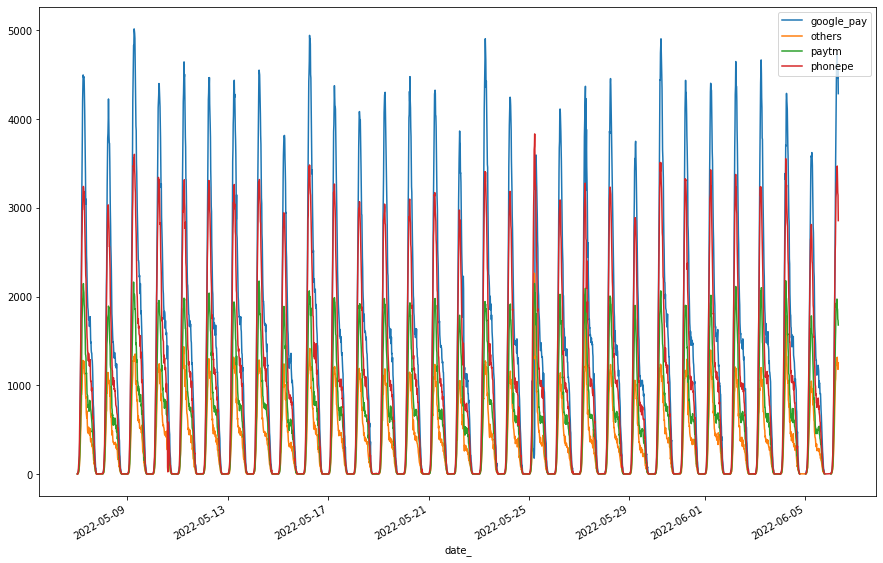

In [9]:
df.plot(figsize=(15,10))

<AxesSubplot:xlabel='date_'>

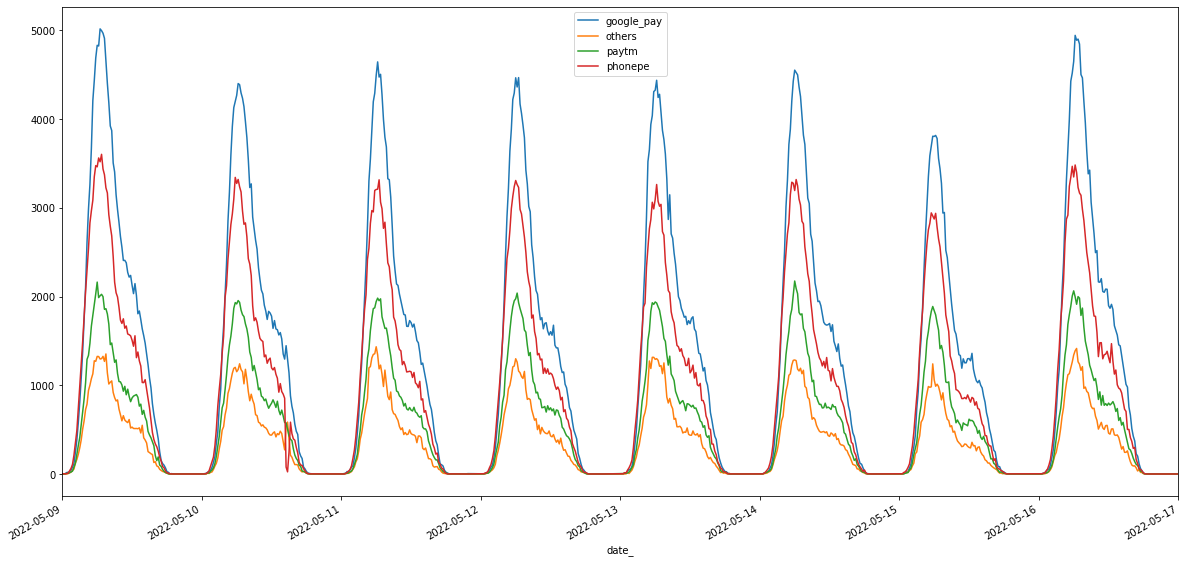

In [10]:
# Analyzing over the interval ['2022-05-09', '2022-05-17']
df.plot(xlim = (['2022-05-09', '2022-05-17']),figsize=(20,10))

<AxesSubplot:xlabel='date_'>

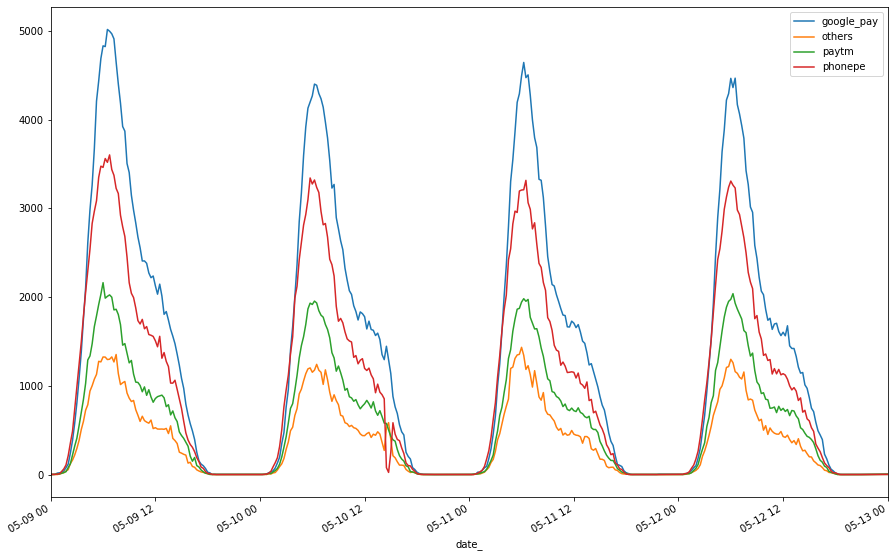

In [11]:
# Analyzing over a certainly lower interval ['2022-05-09', '2022-05-13']
df.plot(xlim = (['2022-05-09', '2022-05-13']),figsize=(15,10))

In [12]:
df['google_pay']

date_
2022-05-07 00:15:00       0.0
2022-05-07 00:30:00       0.0
2022-05-07 00:45:00       9.0
2022-05-07 01:00:00      23.0
2022-05-07 01:15:00      30.0
                        ...  
2022-06-06 06:45:00    4717.0
2022-06-06 07:00:00    4553.0
2022-06-06 07:15:00    4463.0
2022-06-06 07:30:00    4562.0
2022-06-06 07:45:00    4287.0
Name: google_pay, Length: 2308, dtype: float64

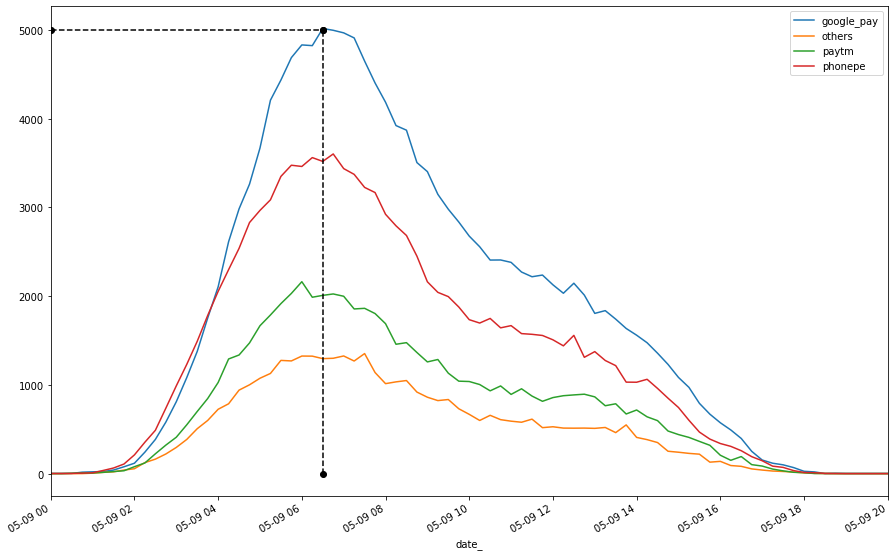

In [13]:
# Analyzing the trend in data over the interval ['2022-05-09 00:00', '2022-05-09 20:00']
df.plot(xlim = (['2022-05-09 00:00', '2022-05-09 20:00']),figsize=(15,10))
plt.plot((datetime(2022,5,9,0,0), datetime(2022,5,9,6,30)), (5000, 5000), marker='o', linestyle='--', color='black')
plt.plot((datetime(2022,5,9,6,30), datetime(2022,5,9,6,30)), (0, 5000), marker='o', linestyle='--', color='black')

## Broad Conclusion:

In [14]:
"""
We can generate a conclusion broadly over the entire dataset:

1. Over the certain interval of (2022-05-09 00:00) till (2022-05-09 20:00), we can observe a cetain
   upward trend till (2022-05-09 06:30) and downward trend henceforth but no upward or downward trend in the generalized
   dataset.

2. The entire data shows seasonality over a certain defined interval. This interval can be later analyzed using statistical means.

3. As from the profile report generated and even from the various plots we can concluded that our dataset is stationary overall.
   This can be broadly verified as there is no certain change in the mean and the standard deviation in the data over entire
   time interval of our data.
   This can be verified statistically using Dickey-Fuller Test.
   
4. There exist a certain level of noise which is very minimal and can be worked on later during the model building phase. 

"""
### Trend, seasonality, stationary, no noise, 

'\nWe can generate a conclusion broadly over the entire dataset:\n\n1. Over the certain interval of (2022-05-09 00:00) till (2022-05-09 20:00), we can observe a cetain\n   upward trend till (2022-05-09 06:30) and downward trend henceforth but no upward or downward trend in the generalized\n   dataset.\n\n2. The entire data shows seasonality over a certain defined interval. This interval can be later analyzed using statistical means.\n\n3. As from the profile report generated and even from the various plots we can concluded that our dataset is stationary overall.\n   This can be broadly verified as there is no certain change in the mean and the standard deviation in the data over entire\n   time interval of our data.\n   This can be verified statistically using Dickey-Fuller Test.\n   \n4. There exist a certain level of noise which is very minimal and can be worked on later during the model building phase. \n\n'

# Individually analyzing each attribute(column) against the required Time Intervals

## Plotting "google_pay" to analyze the 

<AxesSubplot:xlabel='date_'>

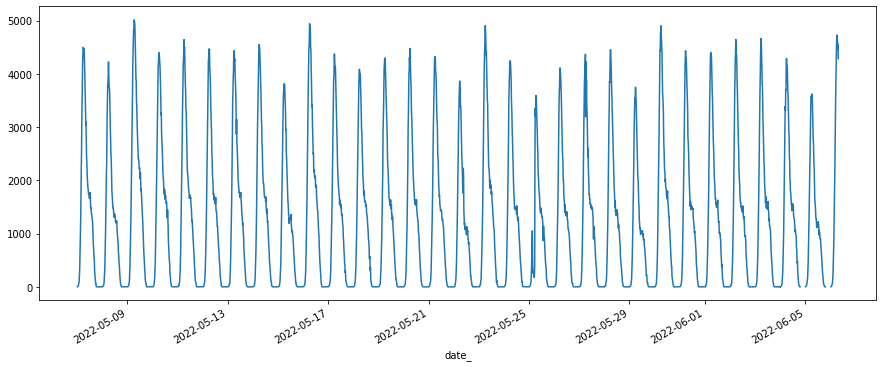

In [15]:
df.google_pay.plot(figsize=(15,6))

<AxesSubplot:xlabel='date_'>

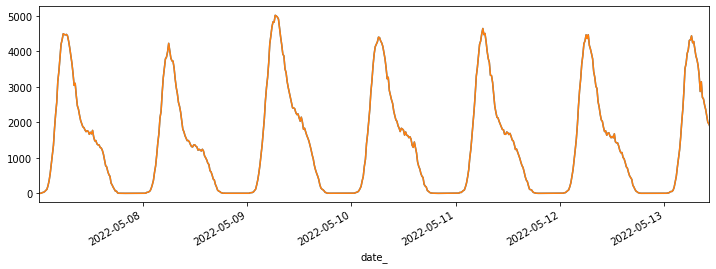

In [16]:
df.google_pay.plot(figsize=(20,10))
df['google_pay'].plot(xlim=['2022-05-07 00:15:00','2022-05-13 10:15:00'],figsize=(12,4))

<AxesSubplot:xlabel='date_'>

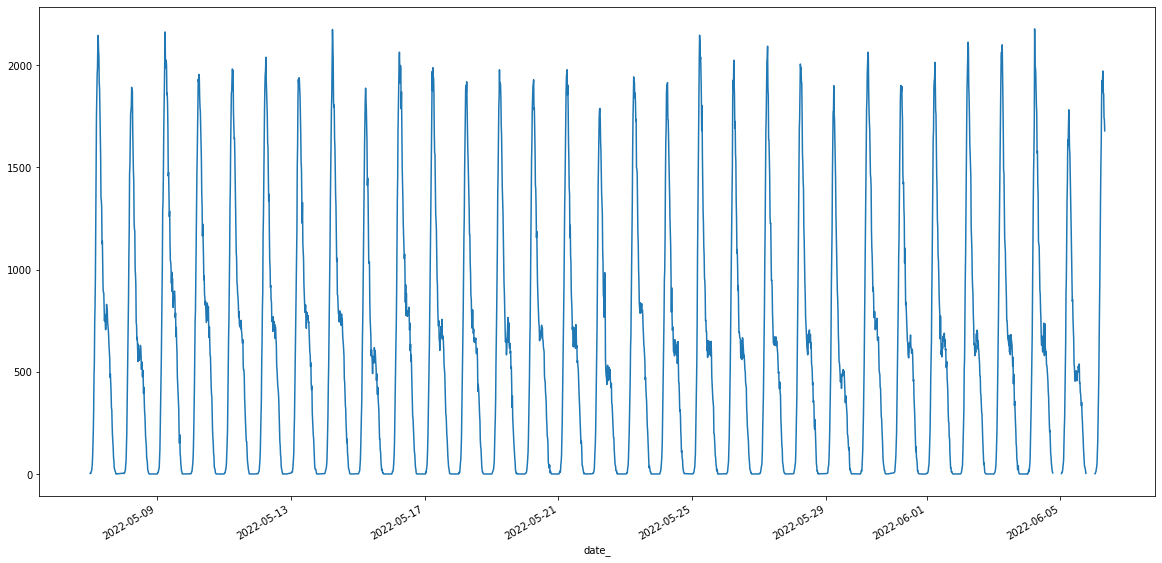

In [17]:
df.paytm.plot(figsize=(20,10))

<AxesSubplot:xlabel='date_'>

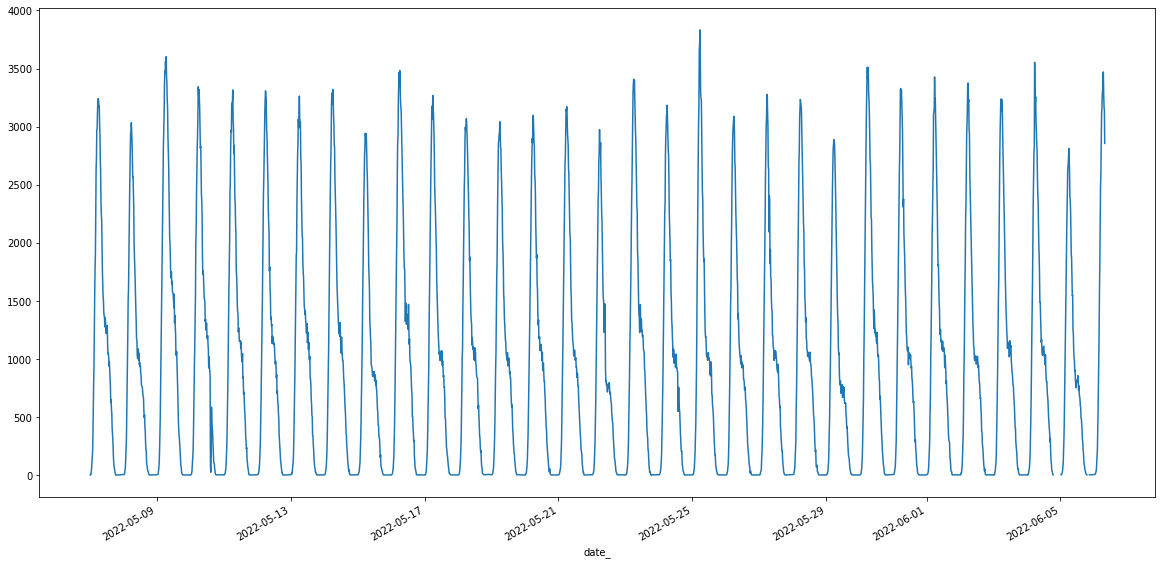

In [18]:
df.phonepe.plot(figsize=(20,10))

<AxesSubplot:xlabel='date_'>

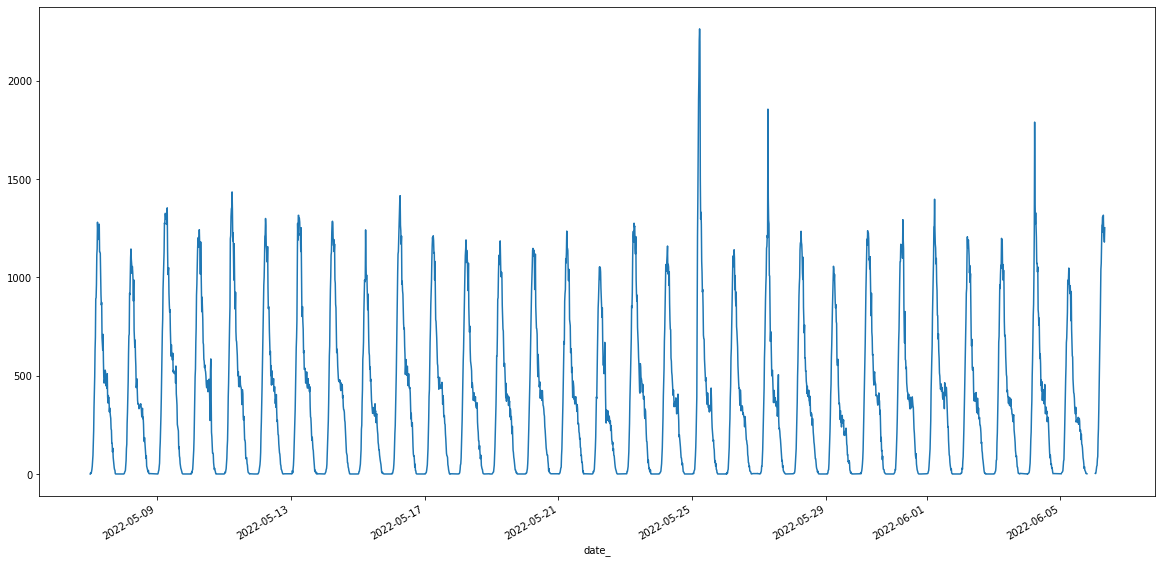

In [19]:
# date vs google_pay -> 
df.others.plot(figsize=(20,10))

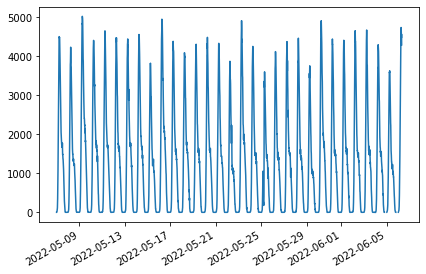

In [20]:
figure,axis=plt.subplots()
plt.tight_layout()
## Preventing overlapping
figure.autofmt_xdate()
axis.plot(df.index,df.google_pay)

In [21]:
df

google_pay  others   paytm  phonepe
date_                                                   
2022-05-07 00:15:00         0.0     0.0     3.0      0.0
2022-05-07 00:30:00         0.0     5.0     2.0      5.0
2022-05-07 00:45:00         9.0     2.0     3.0      4.0
2022-05-07 01:00:00        23.0     5.0    13.0     26.0
2022-05-07 01:15:00        30.0    13.0    15.0     56.0
...                         ...     ...     ...      ...
2022-06-06 06:45:00      4717.0  1316.0  1864.0   3471.0
2022-06-06 07:00:00      4553.0  1237.0  1860.0   3289.0
2022-06-06 07:15:00      4463.0  1206.0  1745.0   3171.0
2022-06-06 07:30:00      4562.0  1179.0  1733.0   3143.0
2022-06-06 07:45:00      4287.0  1252.0  1679.0   2856.0

[2308 rows x 4 columns]

# Performing Time Resampling for better analysis

In [22]:
# Resampling data for maximum data that got changed for year end basis
df.resample(rule='A').mean()

google_pay     others       paytm      phonepe
date_                                                      
2022-12-31  1538.390191  434.06997  689.084421  1153.199219

D:\College Softwares\Anaconda\envs\fsds_ml\lib\site-packages\pandas\plotting\_matplotlib\core.py:1136: UserWarning: Attempting to set identical left == right == 52.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
D:\College Softwares\Anaconda\envs\fsds_ml\lib\site-packages\pandas\plotting\_matplotlib\core.py:1136: UserWarning: Attempting to set identical left == right == 52.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
D:\College Softwares\Anaconda\envs\fsds_ml\lib\site-packages\pandas\plotting\_matplotlib\core.py:1136: UserWarning: Attempting to set identical left == right == 52.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
D:\College Softwares\Anaconda\envs\fsds_ml\lib\site-packages\pandas\plotting\_matplotlib\core.py:1136: UserWarning: Attempting to set identical left == right == 52.0 results in singular transformations; automatically expanding.
  ax.se

<AxesSubplot:xlabel='date_'>

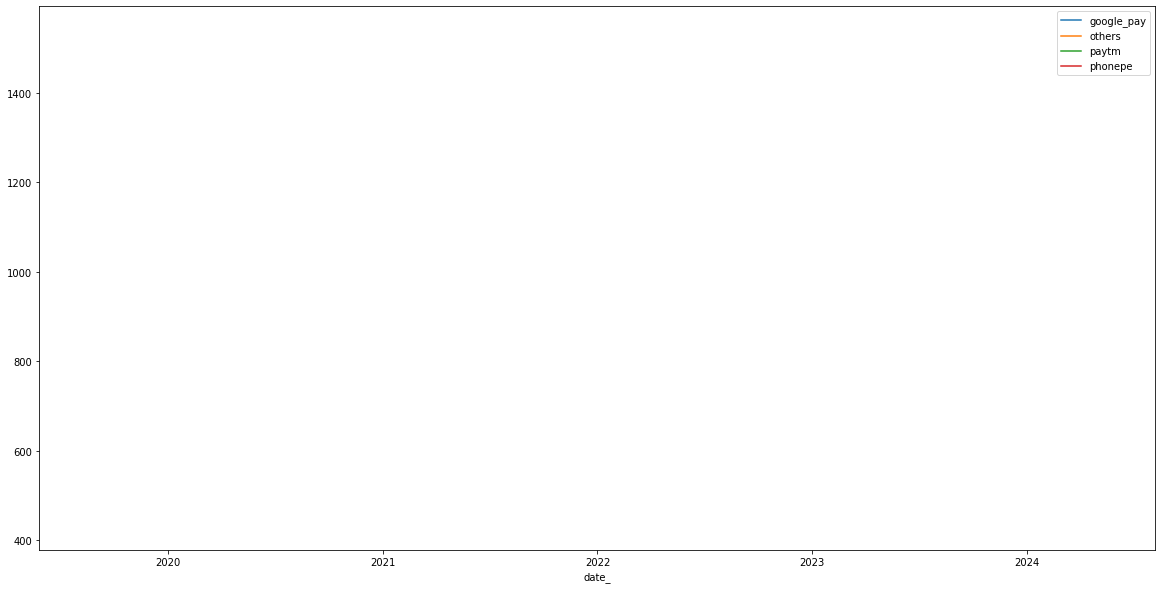

In [23]:
# Resampling data for maximum data that got changed for year end basis
df.resample(rule='A').mean().plot(figsize=(20,10))

In [24]:
# Resampling data for maximum data that got changed at month starting
df.resample(rule='MS').mean()

google_pay      others       paytm      phonepe
date_                                                       
2022-05-01  1541.767196  435.502646  689.702116  1156.243915
2022-06-01  1522.973430  427.481752  686.223039  1139.299517

<AxesSubplot:xlabel='date_'>

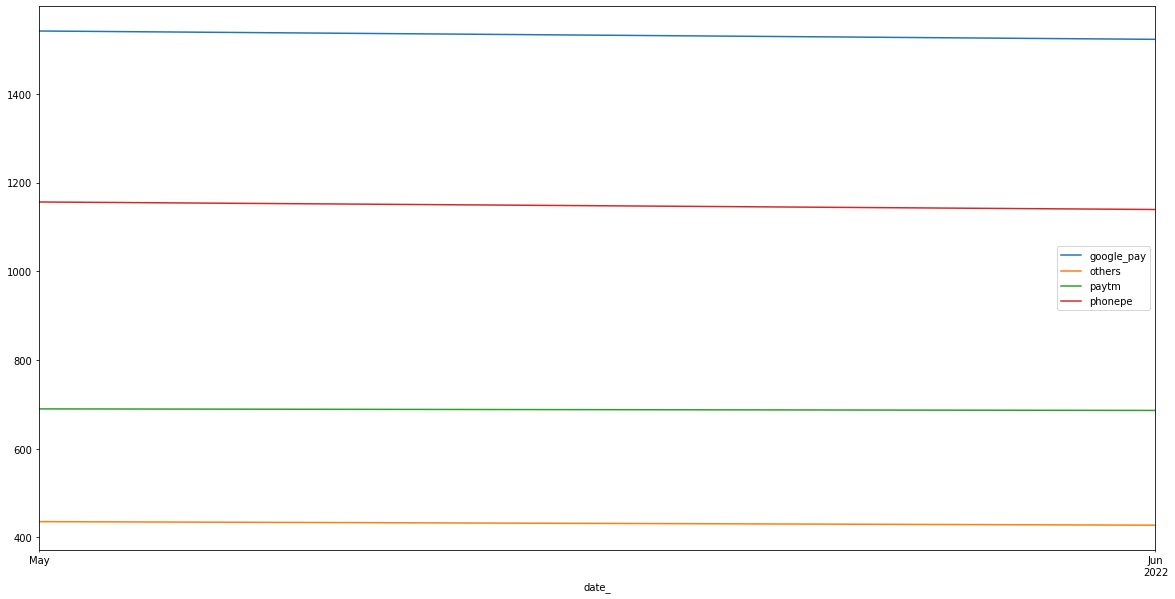

In [25]:
# Resampling data for maximum data that got changed at month starting
df.resample(rule='MS').mean().plot(figsize=(20,10))

In [26]:
# Resampling data for maximum data that got changed at month end
df.resample(rule='M').mean()


google_pay      others       paytm      phonepe
date_                                                       
2022-05-31  1541.767196  435.502646  689.702116  1156.243915
2022-06-30  1522.973430  427.481752  686.223039  1139.299517

<AxesSubplot:xlabel='date_'>

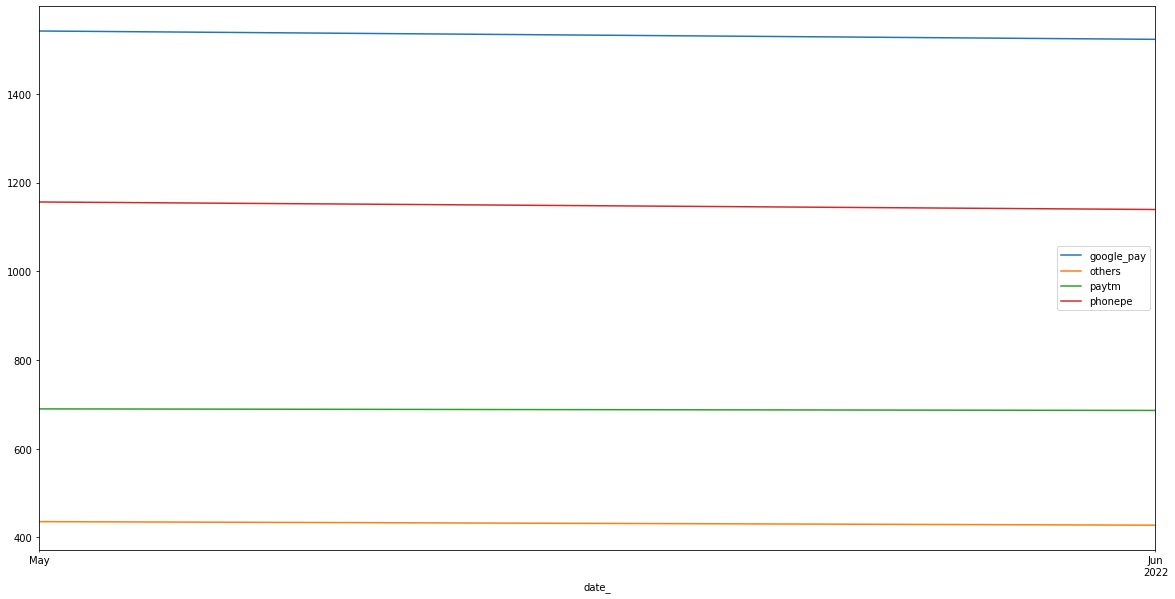

In [27]:
# Resampling data for maximum data that got changed at month end
df.resample(rule='M').mean().plot(figsize=(20,10))

In [28]:
# Resampling data for maximum data that got changed at weekly basis
df.resample(rule='W').mean()

google_pay      others       paytm      phonepe
date_                                                       
2022-05-08  1540.753247  427.896104  692.506494  1148.175325
2022-05-15  1629.033771  459.446529  720.938086  1204.782364
2022-05-22  1543.777567  423.148289  680.826996  1135.475285
2022-05-29  1425.743346  423.623574  663.608365  1114.720532
2022-06-05  1517.500000  418.951311  674.407547  1127.031716
2022-06-12  2191.448276  674.714286  965.551724  1734.862069

<AxesSubplot:xlabel='date_'>

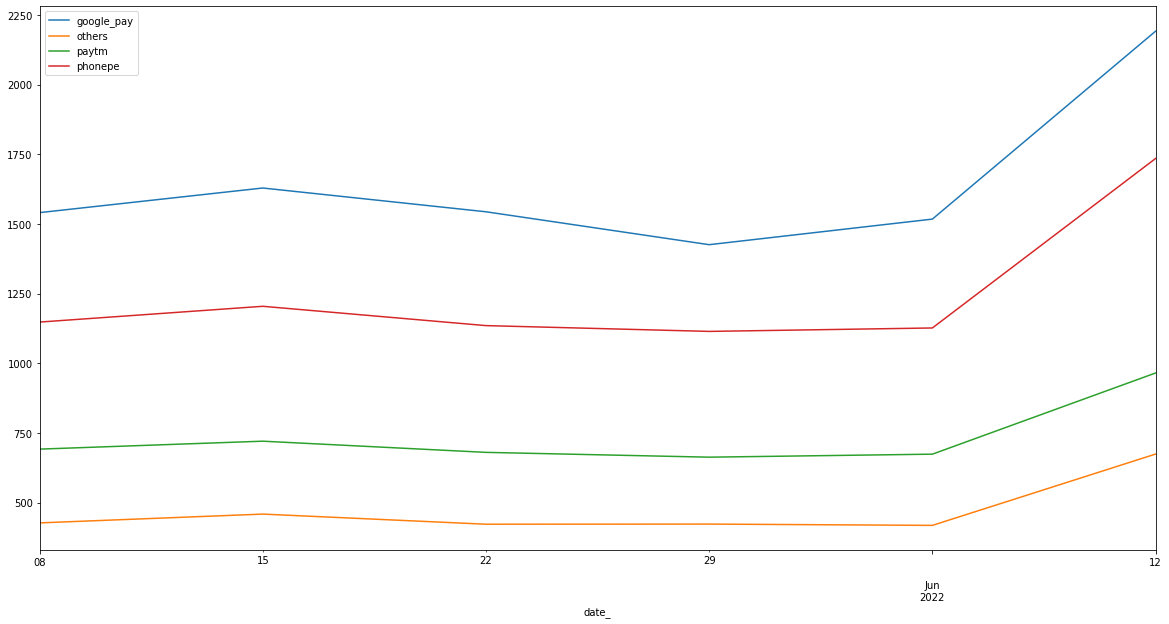

In [29]:
# Resampling data for maximum data that got changed at weekly basis
df.resample(rule='W').mean().plot(figsize=(20,10))

<AxesSubplot:xlabel='date_'>

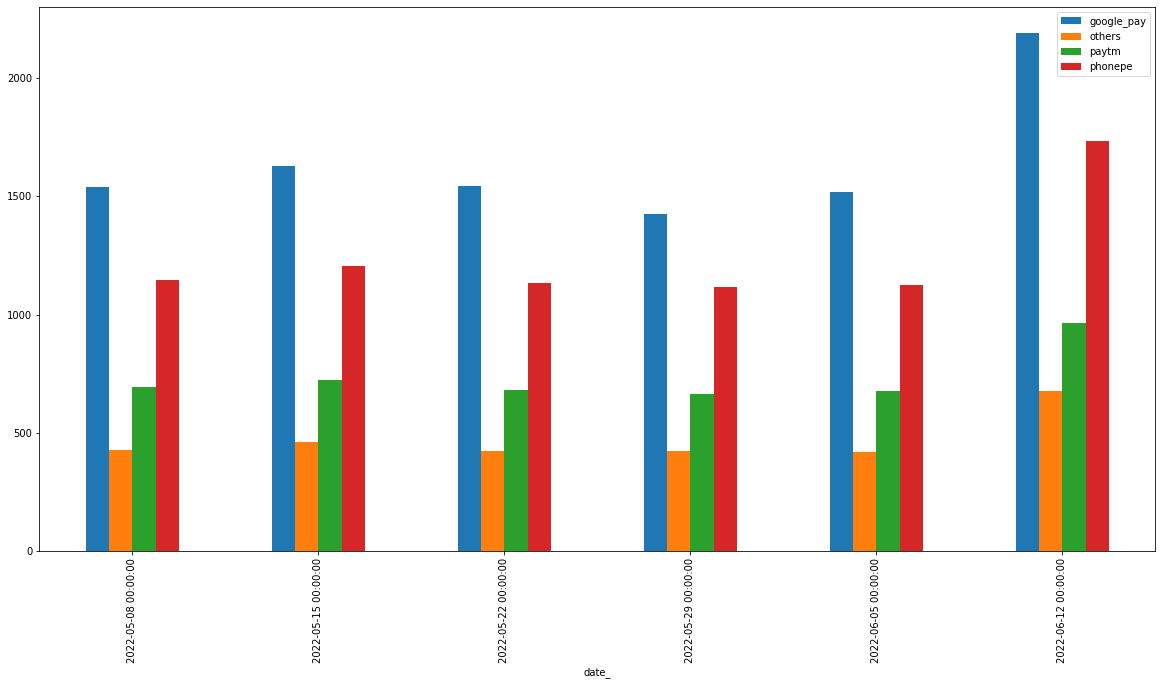

In [30]:
# Resampling data for maximum data that got changed at weekly basis
df.resample(rule='W').mean().plot(kind='bar', figsize=(20,10))

In [31]:
# Resampling data for maximum data that got changed at daily basis
df.resample(rule='D').max()

google_pay  others   paytm  phonepe
date_                                          
2022-05-07      4498.0  1280.0  2146.0   3241.0
2022-05-08      4227.0  1144.0  1892.0   3033.0
2022-05-09      5017.0  1353.0  2163.0   3603.0
2022-05-10      4401.0  1242.0  1955.0   3343.0
2022-05-11      4645.0  1434.0  1982.0   3316.0
2022-05-12      4468.0  1299.0  2039.0   3308.0
2022-05-13      4438.0  1315.0  1939.0   3263.0
2022-05-14      4552.0  1285.0  2175.0   3319.0
2022-05-15      3816.0  1241.0  1888.0   2943.0
2022-05-16      4944.0  1415.0  2064.0   3483.0
2022-05-17      4377.0  1211.0  1988.0   3268.0
2022-05-18      4085.0  1190.0  1919.0   3069.0
2022-05-19      4302.0  1185.0  1978.0   3042.0
2022-05-20      4479.0  1147.0  1929.0   3098.0
2022-05-21      4326.0  1235.0  1978.0   3171.0
2022-05-22      3866.0  1053.0  1789.0   2975.0
2022-05-23      4906.0  1275.0  1943.0   3408.0
2022-05-24      4247.0  1159.0  1915.0   3185.0
2022-05-25      3596.0  2263.0  2147.0   3833.0
2022-05-26      4114.0  1140.0  2025.0   3089.0
2022-05-27      4370.0  1855.0  2093.0   3278.0
2022-05-28      4457.0  1234.0  2006.0   3234.0
2022-05-29      3750.0  1056.0  1900.0   2889.0
2022-05-30      4905.0  1237.0  2064.0   3511.0
2022-05-31      4437.0  1293.0  1901.0   3328.0
2022-06-01      4404.0  1397.0  2014.0   3428.0
2022-06-02      4649.0  1206.0  2113.0   3376.0
2022-06-03      4667.0  1198.0  2100.0   3238.0
2022-06-04      4290.0  1789.0  2178.0   3554.0
2022-06-05      3623.0  1047.0  1782.0   2812.0
2022-06-06      4731.0  1316.0  1972.0   3471.0

<AxesSubplot:xlabel='date_'>

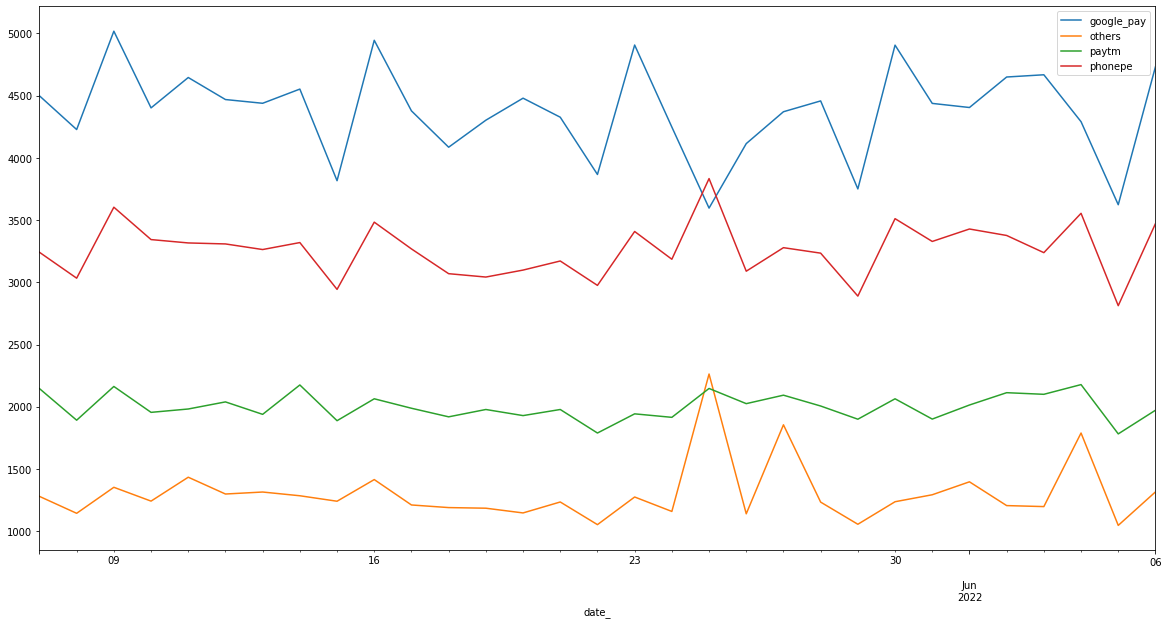

In [32]:
# Resampling data for maximum data that got changed at daily basis
df.resample(rule='D').max().plot(figsize=(20,10))

In [33]:
# Resampling data for data that got changed at daily basis
df.resample(rule='D').min()

google_pay  others  paytm  phonepe
date_                                         
2022-05-07         0.0     0.0    0.0      0.0
2022-05-08         2.0     0.0    0.0      0.0
2022-05-09         1.0     0.0    0.0      0.0
2022-05-10         0.0     0.0    0.0      0.0
2022-05-11         0.0     0.0    0.0      0.0
2022-05-12         0.0     0.0    0.0      0.0
2022-05-13         0.0     0.0    0.0      0.0
2022-05-14         1.0     0.0    0.0      0.0
2022-05-15         1.0     0.0    0.0      0.0
2022-05-16         0.0     0.0    0.0      0.0
2022-05-17         0.0     0.0    0.0      0.0
2022-05-18         0.0     0.0    0.0      0.0
2022-05-19         0.0     0.0    0.0      0.0
2022-05-20         0.0     0.0    0.0      0.0
2022-05-21         0.0     0.0    0.0      0.0
2022-05-22         0.0     0.0    0.0      2.0
2022-05-23         0.0     0.0    0.0      0.0
2022-05-24         1.0     0.0    0.0      0.0
2022-05-25         0.0     0.0    0.0      1.0
2022-05-26         0.0     0.0    0.0      0.0
2022-05-27         0.0     0.0    0.0      0.0
2022-05-28         0.0     0.0    0.0      0.0
2022-05-29         0.0     0.0    0.0      0.0
2022-05-30         0.0     0.0    0.0      0.0
2022-05-31         0.0     0.0    0.0      0.0
2022-06-01         0.0     0.0    0.0      0.0
2022-06-02         0.0     0.0    0.0      0.0
2022-06-03         0.0     0.0    0.0      0.0
2022-06-04         0.0     0.0    0.0      1.0
2022-06-05         1.0     1.0    1.0      1.0
2022-06-06         2.0     2.0    1.0      4.0

<AxesSubplot:xlabel='date_'>

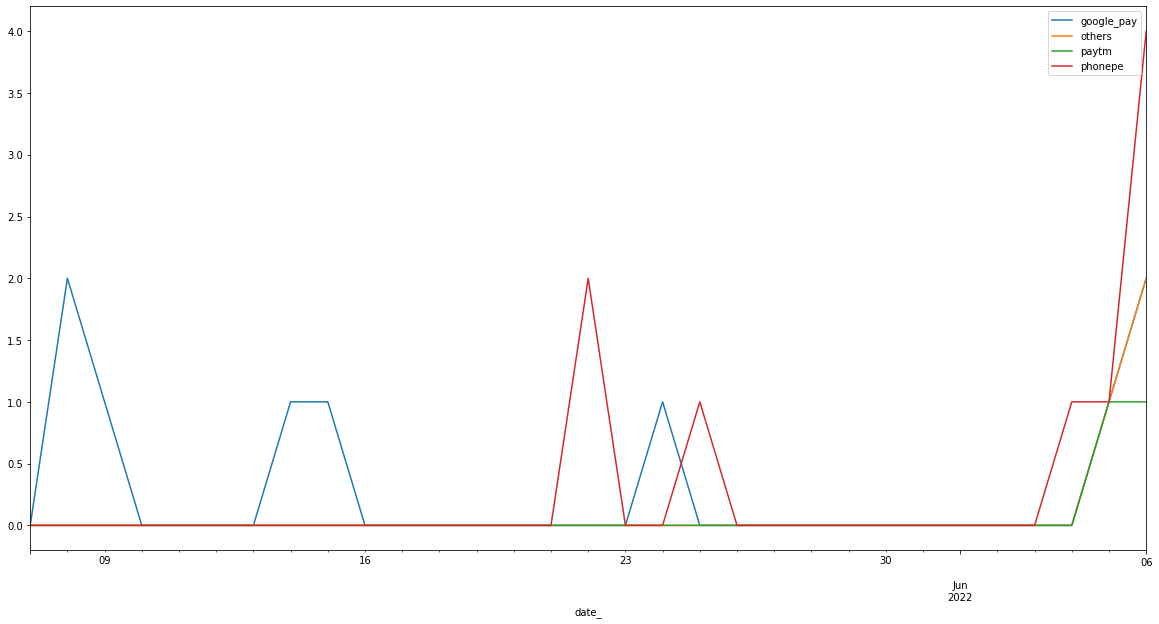

In [34]:
# Resampling data for data that got changed at daily basis
df.resample(rule='D').min().plot(figsize=(20,10))

In [35]:
# Resampling data for mean data that got changed at Daily basis
df.resample(rule='D').mean()

google_pay      others       paytm      phonepe
date_                                                       
2022-05-07  1641.782051  460.846154  737.807692  1231.307692
2022-05-08  1437.065789  394.078947  646.013158  1062.855263
2022-05-09  1931.473684  524.565789  805.210526  1419.197368
2022-05-10  1671.818182  471.623377  739.766234  1207.701299
2022-05-11  1583.730769  457.410256  701.346154  1166.794872
2022-05-12  1576.539474  445.736842  721.315789  1176.815789
2022-05-13  1611.051948  464.259740  709.506494  1179.506494
2022-05-14  1683.094595  478.337838  752.162162  1262.310811
2022-05-15  1344.066667  373.386667  617.133333  1021.546667
2022-05-16  1809.276316  488.118421  758.013158  1318.276316
2022-05-17  1573.648649  443.851351  703.175676  1167.027027
2022-05-18  1470.610390  406.493506  662.103896  1097.610390
2022-05-19  1557.256757  418.824324  693.472973  1117.243243
2022-05-20  1536.842105  414.605263  675.157895  1108.710526
2022-05-21  1550.240000  425.653333  687.226667  1157.146667
2022-05-22  1304.459459  363.608108  585.378378   979.337838
2022-05-23  1702.447368  449.092105  700.289474  1231.210526
2022-05-24  1532.297297  413.756757  661.121622  1127.148649
2022-05-25  1104.453333  527.226667  701.866667  1187.800000
2022-05-26  1373.679487  370.602564  632.833333  1026.217949
2022-05-27  1486.880000  433.520000  682.933333  1105.600000
2022-05-28  1542.135135  428.864865  693.175676  1163.608108
2022-05-29  1237.162162  342.945946  572.932432   962.229730
2022-05-30  1718.947368  452.263158  726.921053  1269.197368
2022-05-31  1543.746667  433.933333  669.493333  1150.280000
2022-06-01  1545.473684  443.881579  678.118421  1156.973684
2022-06-02  1454.197531  385.049383  652.222222  1067.950617
2022-06-03  1563.710526  407.881579  689.065789  1141.986842
2022-06-04  1532.144737  451.118421  705.770270  1158.526316
2022-06-05  1268.789474  359.391892  597.430556   948.500000
2022-06-06  2191.448276  674.714286  965.551724  1734.862069

<AxesSubplot:xlabel='date_'>

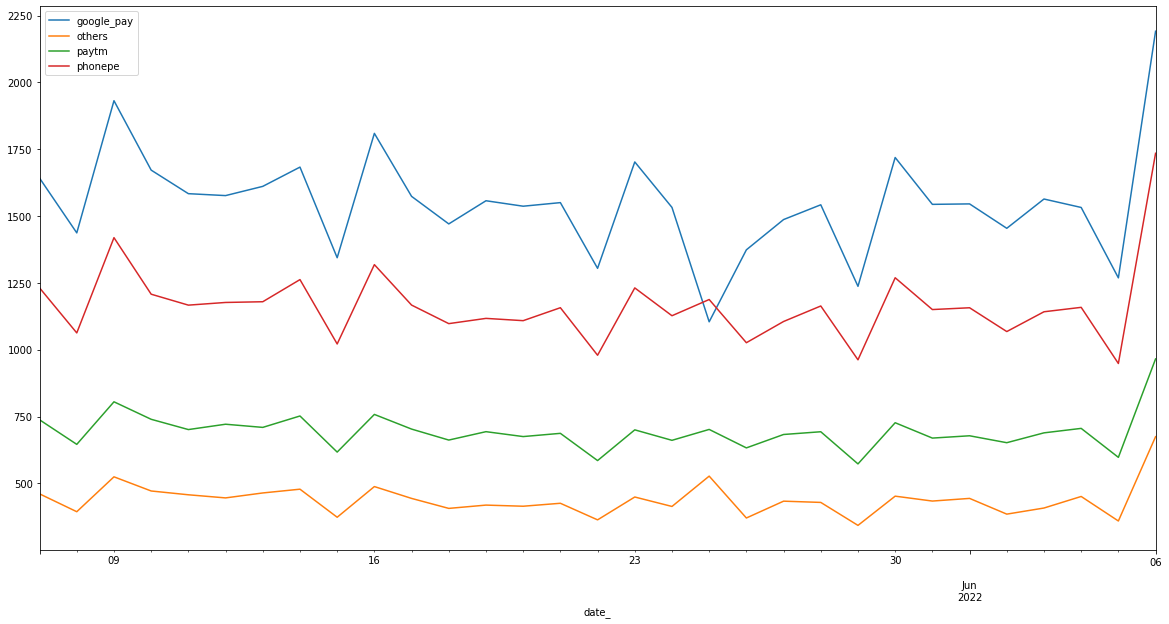

In [36]:
# Resampling data for mean data that got changed at Daily basis
df.resample(rule='D').mean().plot(figsize=(20,10))

<AxesSubplot:xlabel='date_'>

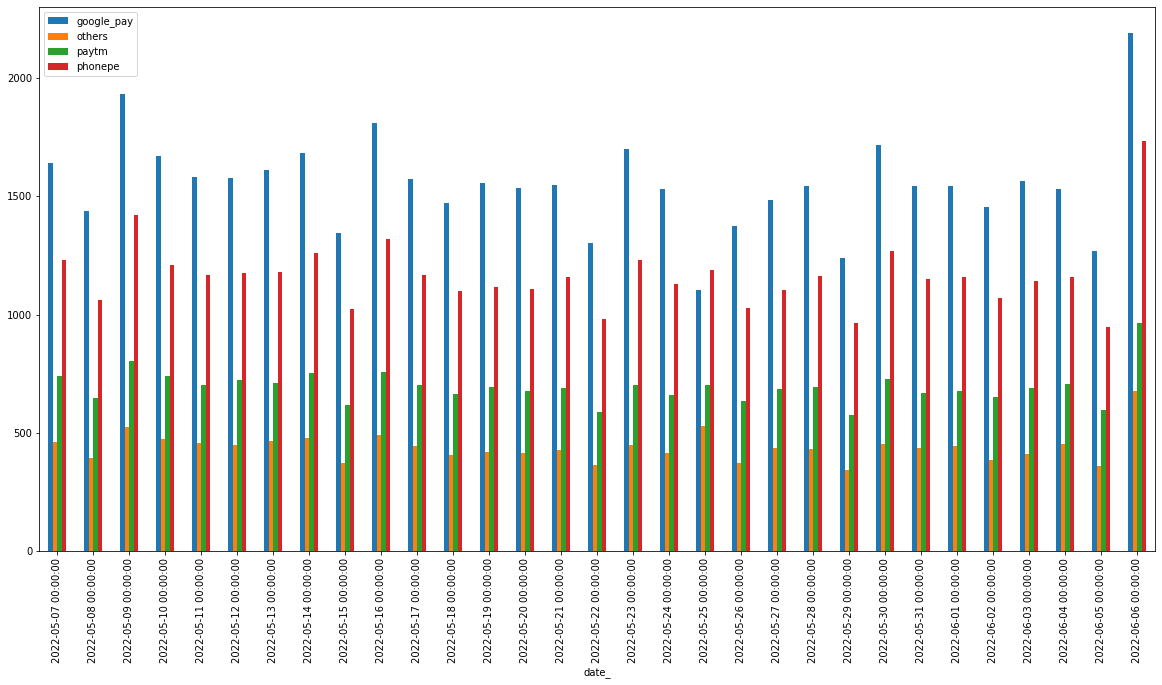

In [37]:
# Resampling data for mean data that got changed at Daily basis
df.resample(rule='D').mean().plot(kind='bar', figsize=(20,10))

In [38]:
# Resampling data for minimum data that got changed at Hourly basis
df.resample(rule='H').min()

google_pay  others   paytm  phonepe
date_                                                   
2022-05-07 00:00:00         0.0     0.0     2.0      0.0
2022-05-07 01:00:00        23.0     5.0    13.0     26.0
2022-05-07 02:00:00       114.0    64.0    84.0    207.0
2022-05-07 03:00:00       834.0   338.0   476.0    962.0
2022-05-07 04:00:00      2234.0   695.0   962.0   1891.0
...                         ...     ...     ...      ...
2022-06-06 03:00:00       434.0   180.0   266.0    562.0
2022-06-06 04:00:00      1452.0   547.0   810.0   1600.0
2022-06-06 05:00:00      3184.0  1040.0  1513.0   2590.0
2022-06-06 06:00:00      4488.0  1229.0  1864.0   3281.0
2022-06-06 07:00:00      4287.0  1179.0  1679.0   2856.0

[728 rows x 4 columns]

<AxesSubplot:xlabel='date_'>

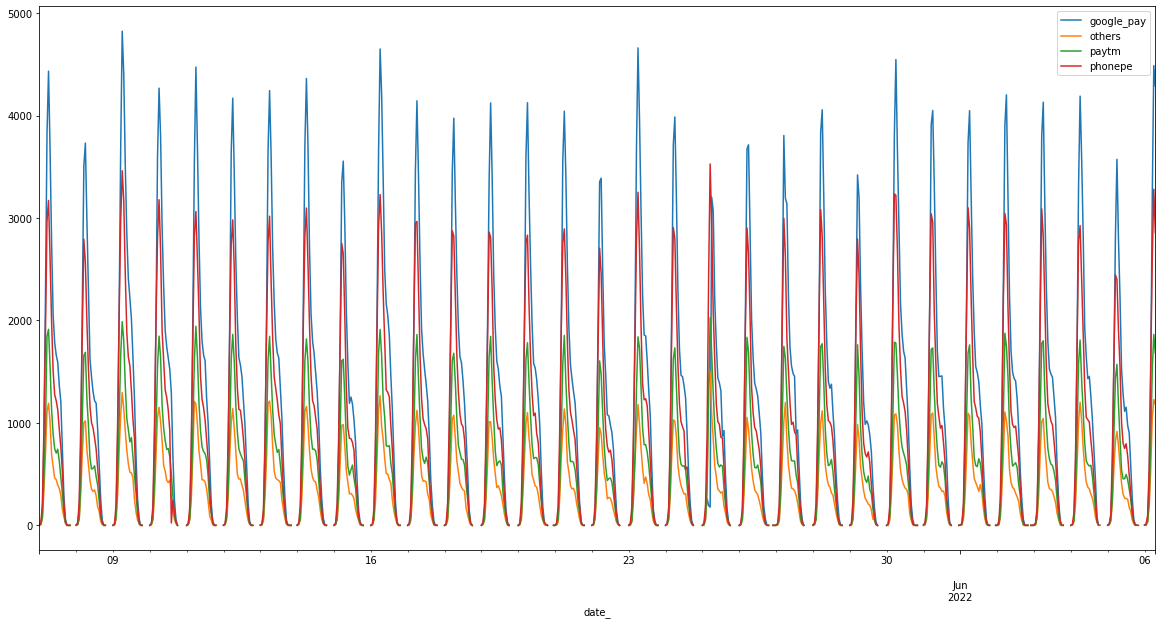

In [39]:
# Resampling data for minimum data that got changed at Hourly basis
df.resample(rule='H').min().plot(figsize=(20,10))

In [40]:
# Resampling data for maximum data that got changed at Hourly basis
df.resample(rule='H').max()

google_pay  others   paytm  phonepe
date_                                                   
2022-05-07 00:00:00         9.0     5.0     3.0      5.0
2022-05-07 01:00:00        83.0    40.0    46.0    151.0
2022-05-07 02:00:00       556.0   219.0   315.0    794.0
2022-05-07 03:00:00      1837.0   630.0   830.0   1776.0
2022-05-07 04:00:00      3439.0   963.0  1745.0   2727.0
...                         ...     ...     ...      ...
2022-06-06 03:00:00      1202.0   448.0   659.0   1260.0
2022-06-06 04:00:00      2755.0   912.0  1352.0   2492.0
2022-06-06 05:00:00      4332.0  1264.0  1925.0   3157.0
2022-06-06 06:00:00      4731.0  1316.0  1972.0   3471.0
2022-06-06 07:00:00      4562.0  1252.0  1860.0   3289.0

[728 rows x 4 columns]

<AxesSubplot:xlabel='date_'>

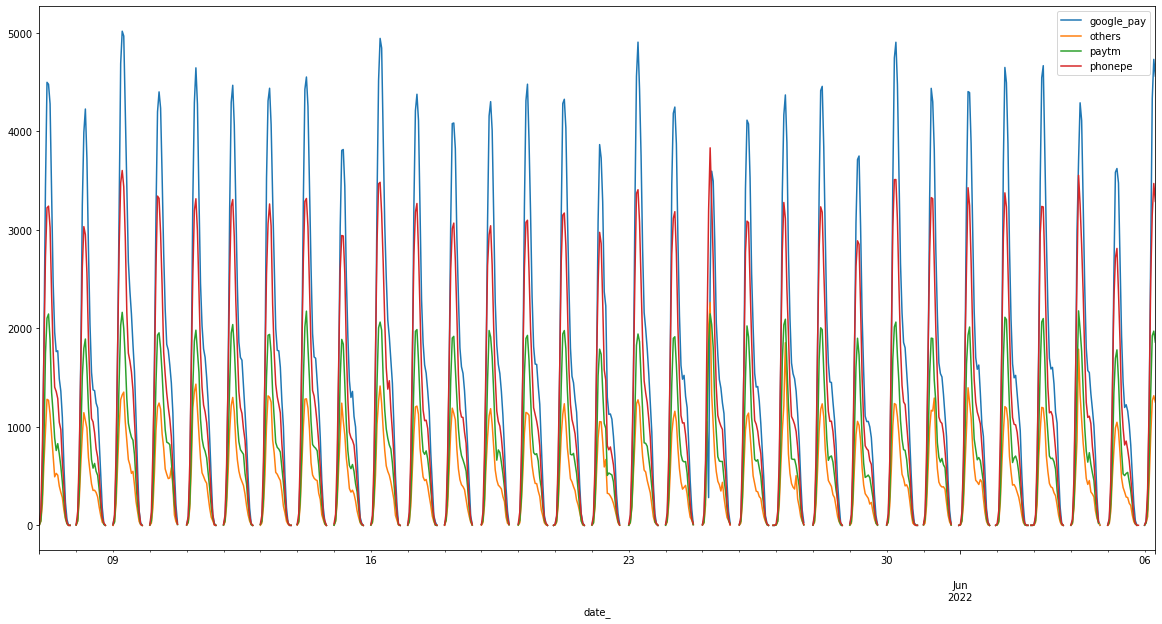

In [41]:
# Resampling data for maximum data that got changed at Hourly basis
df.resample(rule='H').max().plot(figsize=(20,10))

<AxesSubplot:xlabel='date_'>

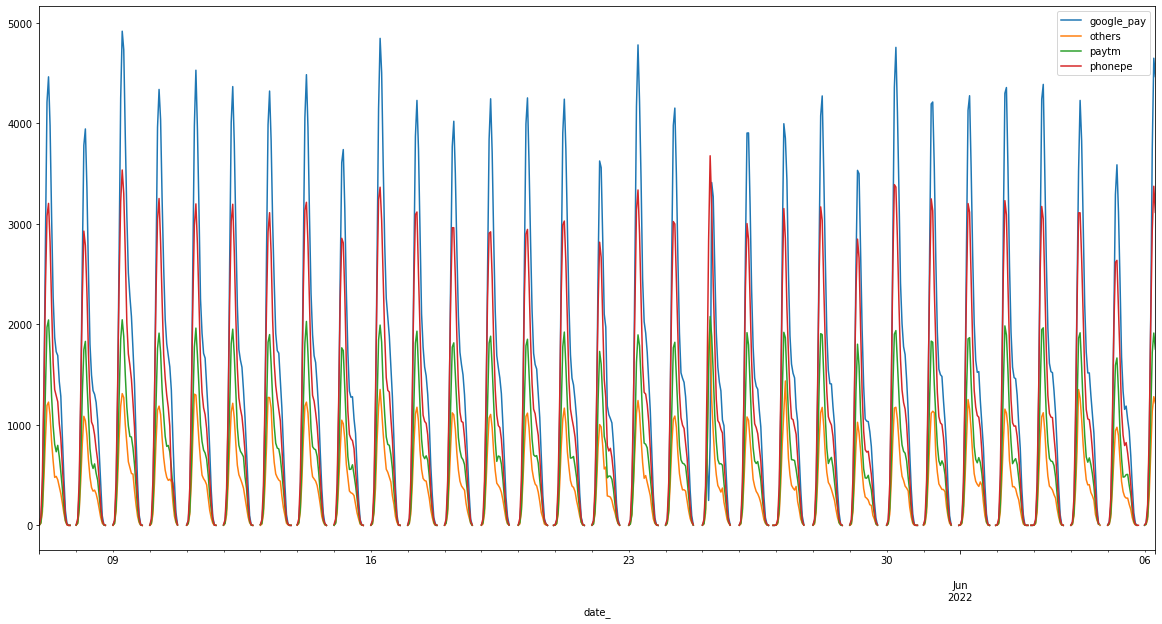

In [42]:
# Resampling data for mean data that got changed at Hourly basis
df.resample(rule='H').mean().plot(figsize=(20,10))

In [43]:
# Resampling data for mean data that got changed at Minute level basis
df.resample(rule='T').mean()

google_pay  others   paytm  phonepe
date_                                                   
2022-05-07 00:15:00         0.0     0.0     3.0      0.0
2022-05-07 00:16:00         NaN     NaN     NaN      NaN
2022-05-07 00:17:00         NaN     NaN     NaN      NaN
2022-05-07 00:18:00         NaN     NaN     NaN      NaN
2022-05-07 00:19:00         NaN     NaN     NaN      NaN
...                         ...     ...     ...      ...
2022-06-06 07:41:00         NaN     NaN     NaN      NaN
2022-06-06 07:42:00         NaN     NaN     NaN      NaN
2022-06-06 07:43:00         NaN     NaN     NaN      NaN
2022-06-06 07:44:00         NaN     NaN     NaN      NaN
2022-06-06 07:45:00      4287.0  1252.0  1679.0   2856.0

[43651 rows x 4 columns]

<AxesSubplot:xlabel='date_'>

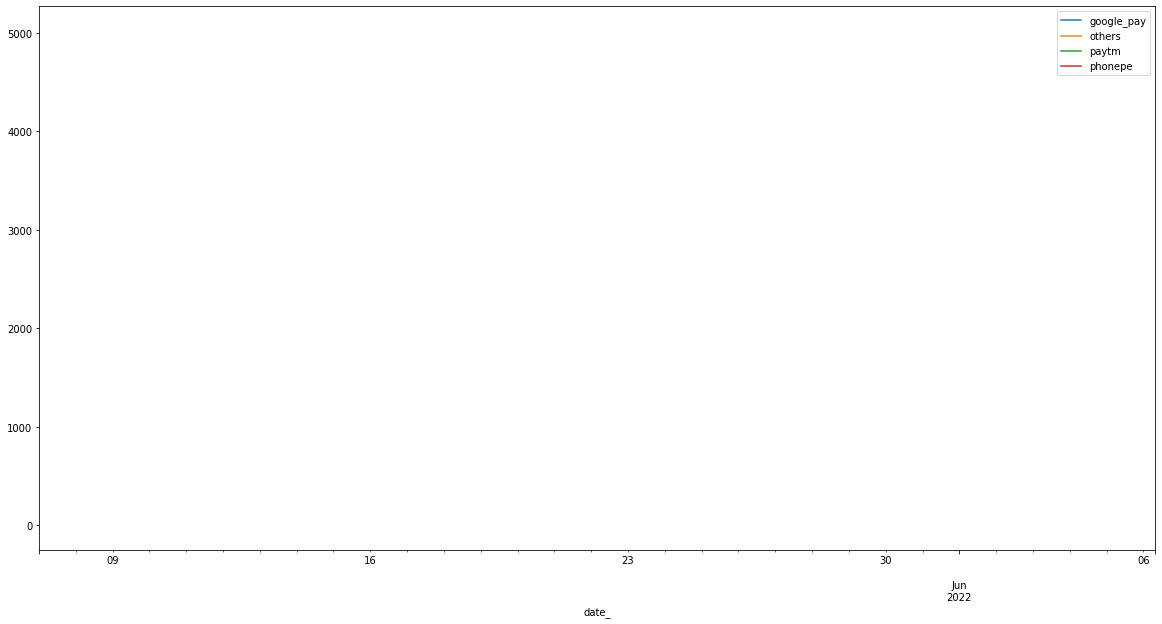

In [44]:
# Resampling data for mean data that got changed at Minute level basis
df.resample(rule='T').mean().plot(figsize=(20,10))

## Broad Conclusions:

# Various conclusions can be generated as:
## 1. After resampling and observing the changes in our data for different segments/time intervals, we can say that:

(a) Yearly Analysis for changes at Year End:
  > For Year End Resampling, only one major change in the data was found for the maximum, minimum and mean aggregation.
  > This was even observed through the graph.
    
(b) Monthly Analysis for changes at Month Starting:
  > For the Monthly Starting Frequency Sampling, slight or no certainly high(spike) changes were observed.
  > After observing the numerical values also it was observed that only at 2 particular datetimes(2022-05-01 and 2022-06-01), 
    a slight dispersion in all attributes were observed.
  > This was even observed through the graph. Here, the graph was almost a dispersed line.

(c) Monthly Analysis for changes at Month Ending: 
  > For the Monthly End Frequency Sampling, similar trend or pattern was observed as at in the Starting of the Month.
  > After observing the numerical values also it was observed that only at 2 particular datetimes(2022-05-30 and 2022-06-31),
    a slight dispersion in all attributes were observed.
  > This was even observed through the graph. Here, the graph was almost a dispersed line.

## Now as there were changes in the trend (yet not so significant were observed so analysis the resampling for further lower time intervals

(d) Weakly Changes Analysis:
  > Now after Weakly Resampling, furthur changes were observed in our dataset over time.
  > As it was observed in the resampled data that number of dispersed/changed trend increased as compared to previous      durations.
  > Yet there was very slight change in pattern in our data for lower time period but during the beginning week for the month of June 2022. This change is very significant as the spike was really high and did not matched any previous pattern.

## Now resampling our data for lower intervals to analyze the spike observed from the previous observations

(e) Daily Change Analysis:
  > At the daily level, for different attributes different patterns were observed.
    (i)  Google Pay, (ii) Phone Pe, (iii) Paytm, (iv) Others
  > Even though the values for the corresponding attribute were at different scaled, but when considered individually they showed direct relation with the Time Intervals. It should be noted that it was for Daily level Resampling.
  > One more important thing to be noted is that each attribute showcases stationary pattern that is having a ~constant mean and standard deviation.
  > This can furthur be analyzed using the Statistical Dickey Fuller Test.
  > This can even be seen through the graph.

## Even though we observed major key points from Daily Resampling method but analyzing for Hourly Basis
  
(f) Hourly Change Analysis:
  > For hourly basis it was also observed when we earlier plotted our generalized dataset.
  > So this was fairly expected.
  > From the graph we can verify the similar trends showcased by each attribute to the time interval thus showcasing the direct relationships over a broad level.
  > Again we can see the stationarity in our dataset.

## Even though it is not necessary for further resampling but analyzing at minute level
  
(f) Minute Level Change Analysis:
  > At minute level there was such frequency change at this level.
  > This can be easily observed from the graph too.
  
## So no further analysis to be performed for lower time intervals(seconds or miliseconds)


In [45]:
# Data
df

google_pay  others   paytm  phonepe
date_                                                   
2022-05-07 00:15:00         0.0     0.0     3.0      0.0
2022-05-07 00:30:00         0.0     5.0     2.0      5.0
2022-05-07 00:45:00         9.0     2.0     3.0      4.0
2022-05-07 01:00:00        23.0     5.0    13.0     26.0
2022-05-07 01:15:00        30.0    13.0    15.0     56.0
...                         ...     ...     ...      ...
2022-06-06 06:45:00      4717.0  1316.0  1864.0   3471.0
2022-06-06 07:00:00      4553.0  1237.0  1860.0   3289.0
2022-06-06 07:15:00      4463.0  1206.0  1745.0   3171.0
2022-06-06 07:30:00      4562.0  1179.0  1733.0   3143.0
2022-06-06 07:45:00      4287.0  1252.0  1679.0   2856.0

[2308 rows x 4 columns]

In [46]:
df.head(50)

google_pay  others   paytm  phonepe
date_                                                   
2022-05-07 00:15:00         0.0     0.0     3.0      0.0
2022-05-07 00:30:00         0.0     5.0     2.0      5.0
2022-05-07 00:45:00         9.0     2.0     3.0      4.0
2022-05-07 01:00:00        23.0     5.0    13.0     26.0
2022-05-07 01:15:00        30.0    13.0    15.0     56.0
2022-05-07 01:30:00        52.0    24.0    27.0    106.0
2022-05-07 01:45:00        83.0    40.0    46.0    151.0
2022-05-07 02:00:00       114.0    64.0    84.0    207.0
2022-05-07 02:15:00       216.0    95.0   140.0    359.0
2022-05-07 02:30:00       355.0   156.0   209.0    603.0
2022-05-07 02:45:00       556.0   219.0   315.0    794.0
2022-05-07 03:00:00       834.0   338.0   476.0    962.0
2022-05-07 03:15:00      1089.0   415.0   545.0   1272.0
2022-05-07 03:30:00      1354.0   495.0   745.0   1567.0
2022-05-07 03:45:00      1837.0   630.0   830.0   1776.0
2022-05-07 04:00:00      2234.0   695.0   962.0   1891.0
2022-05-07 04:15:00      2559.0   891.0  1216.0   2249.0
2022-05-07 04:30:00      3155.0   896.0  1539.0   2635.0
2022-05-07 04:45:00      3439.0   963.0  1745.0   2727.0
2022-05-07 05:00:00      3817.0  1113.0  1844.0   2973.0
2022-05-07 05:15:00      4202.0  1144.0  1955.0   2980.0
2022-05-07 05:30:00      4330.0  1280.0  1988.0   3134.0
2022-05-07 05:45:00      4498.0  1237.0  2103.0   3224.0
2022-05-07 06:00:00      4476.0  1232.0  2146.0   3241.0
2022-05-07 06:15:00      4466.0  1213.0  2073.0   3226.0
2022-05-07 06:30:00      4478.0  1192.0  2045.0   3172.0
2022-05-07 06:45:00      4434.0  1270.0  1914.0   3177.0
2022-05-07 07:00:00      4279.0  1129.0  1881.0   3024.0
2022-05-07 07:15:00      4093.0  1128.0  1768.0   2936.0
2022-05-07 07:30:00      3879.0  1122.0  1641.0   2713.0
2022-05-07 07:45:00      3663.0  1005.0  1555.0   2607.0
2022-05-07 08:00:00      3379.0   912.0  1349.0   2348.0
2022-05-07 08:15:00      3043.0   859.0  1339.0   2241.0
2022-05-07 08:30:00      3099.0   872.0  1305.0   2196.0
2022-05-07 08:45:00      2750.0   693.0  1126.0   1982.0
2022-05-07 09:00:00      2467.0   656.0  1140.0   1769.0
2022-05-07 09:15:00      2370.0   629.0  1033.0   1652.0
2022-05-07 09:30:00      2201.0   710.0   904.0   1539.0
2022-05-07 09:45:00      2052.0   572.0   888.0   1506.0
2022-05-07 10:00:00      1960.0   493.0   886.0   1403.0
2022-05-07 10:15:00      1876.0   462.0   812.0   1369.0
2022-05-07 10:30:00      1852.0   478.0   749.0   1358.0
2022-05-07 10:45:00      1786.0   476.0   781.0   1275.0
2022-05-07 11:00:00      1738.0   528.0   760.0   1359.0
2022-05-07 11:15:00      1764.0   519.0   706.0   1319.0
2022-05-07 11:30:00      1747.0   457.0   708.0   1258.0
2022-05-07 11:45:00      1663.0   447.0   756.0   1218.0
2022-05-07 12:00:00      1721.0   477.0   830.0   1269.0
2022-05-07 12:15:00      1676.0   435.0   807.0   1234.0
2022-05-07 12:30:00      1773.0   510.0   806.0   1288.0

<AxesSubplot:xlabel='date_'>

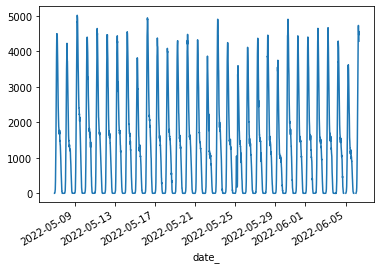

In [47]:
df.google_pay.plot()

In [48]:
df

google_pay  others   paytm  phonepe
date_                                                   
2022-05-07 00:15:00         0.0     0.0     3.0      0.0
2022-05-07 00:30:00         0.0     5.0     2.0      5.0
2022-05-07 00:45:00         9.0     2.0     3.0      4.0
2022-05-07 01:00:00        23.0     5.0    13.0     26.0
2022-05-07 01:15:00        30.0    13.0    15.0     56.0
...                         ...     ...     ...      ...
2022-06-06 06:45:00      4717.0  1316.0  1864.0   3471.0
2022-06-06 07:00:00      4553.0  1237.0  1860.0   3289.0
2022-06-06 07:15:00      4463.0  1206.0  1745.0   3171.0
2022-06-06 07:30:00      4562.0  1179.0  1733.0   3143.0
2022-06-06 07:45:00      4287.0  1252.0  1679.0   2856.0

[2308 rows x 4 columns]

# Further analyzing the seasonality window for our dataset

## Plotting for various timestamps in order to find the best window for 'google_pay' attribute

<AxesSubplot:xlabel='date_'>

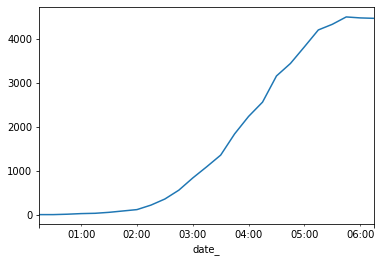

In [49]:
df.google_pay.head(25).plot()

<AxesSubplot:xlabel='date_'>

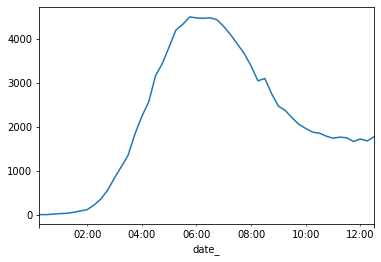

In [50]:
df.google_pay.head(50).plot()

<AxesSubplot:xlabel='date_'>

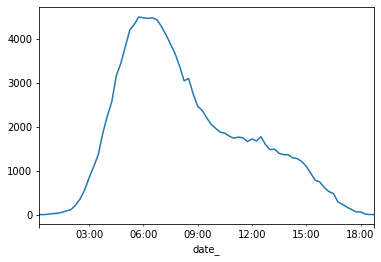

In [51]:
df.google_pay.head(75).plot()

<AxesSubplot:xlabel='date_'>

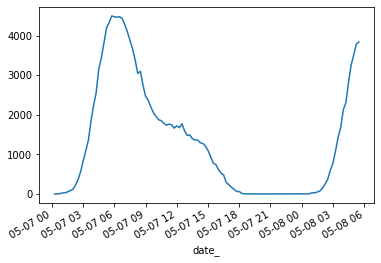

In [52]:
df.google_pay.head(100).plot()

<AxesSubplot:xlabel='date_'>

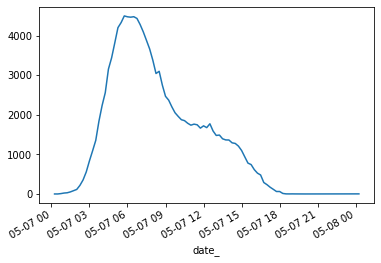

In [53]:
df.google_pay.head(79).plot()

<AxesSubplot:xlabel='date_'>

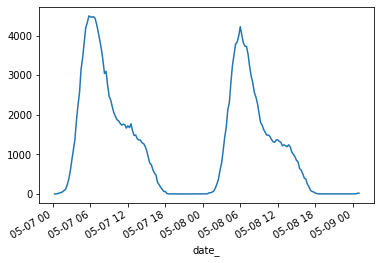

In [54]:
df.google_pay.head(158).plot()

<AxesSubplot:xlabel='date_'>

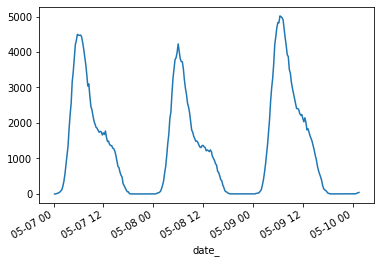

In [55]:
df.google_pay.head(237).plot()

<AxesSubplot:xlabel='date_'>

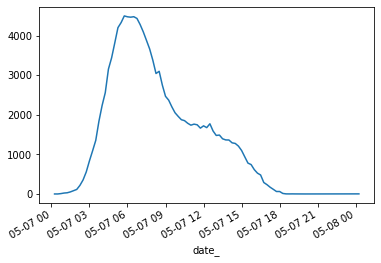

In [56]:
df.google_pay.head(79).plot()

# Dickey Fuller Test:
* Now performing the augmented Fuller Test in order to understand and statistically verify the stationary features of our dataset.
- As from the graph, we came up with the conclusion that our dataset is completely stationary as it showcases a constant mean and standard deviation value.
- But this can be statistically verified and proven using the Dickey-Fuller Test Statsitics. 
- Various Key Points for performing this test:
    - We can define our NULL Hypothesis($H_{0}$) as: The Data is not Stationary. Thus, the Unit Root value(Φ) = 1.
    - Thus, the Alternate Hypothesis($H_{1}$) can be defined as: The Data is Stationary. Thus, the Unit Root value(Φ) < 1
    - 
    
  


In [57]:
df1 = df.dropna(axis=0)

In [58]:
df1

google_pay  others   paytm  phonepe
date_                                                   
2022-05-07 00:15:00         0.0     0.0     3.0      0.0
2022-05-07 00:30:00         0.0     5.0     2.0      5.0
2022-05-07 00:45:00         9.0     2.0     3.0      4.0
2022-05-07 01:00:00        23.0     5.0    13.0     26.0
2022-05-07 01:15:00        30.0    13.0    15.0     56.0
...                         ...     ...     ...      ...
2022-06-06 06:45:00      4717.0  1316.0  1864.0   3471.0
2022-06-06 07:00:00      4553.0  1237.0  1860.0   3289.0
2022-06-06 07:15:00      4463.0  1206.0  1745.0   3171.0
2022-06-06 07:30:00      4562.0  1179.0  1733.0   3143.0
2022-06-06 07:45:00      4287.0  1252.0  1679.0   2856.0

[2295 rows x 4 columns]

In [59]:
def adf_statistics(data):
    
    test_statistics = adfuller(data)
    adf_stats = test_statistics[0]
    p_value = test_statistics[1]
    
    if p_value < 0.05:
        result = "As the p-value is less than 0.05 so there exist strong evidences against the NULL HYPOTHESIS(H0). So there is no existence of Unit Root. And thus, we can reject the NULL HYPOTHESIS(H0) and except the ALTERNATE HYPOTHESIS(H1). Therefore, Data is Stationary"
    else:
        result = "As the p-value is more than 0.05 so there does not exist evidences against the NULL HYPOTHESIS(H0). So there exist Unit Root. And thus, we can reject the ALTERNATE HYPOTHESIS(H1) and accept the NULL HYPOTHESIS(H0). Therefore, Data is Non-Stationary"
    
    print(f"Dickey Fuller Statistics Value: {adf_stats}\n\nP-Value: {p_value}\n\nCONCLUSION: {result}")

## ADF statistics for 'google_pay' attribute

In [60]:
adf_statistics(df1.google_pay)

Dickey Fuller Statistics Value: -12.704712167525226

P-Value: 1.0612325370563679e-23

CONCLUSION: As the p-value is less than 0.05 so there exist strong evidences against the NULL HYPOTHESIS(H0). So there is no existence of Unit Root. And thus, we can reject the NULL HYPOTHESIS(H0) and except the ALTERNATE HYPOTHESIS(H1). Therefore, Data is Stationary


## ADF statistics for 'paytm' attribute

In [61]:
adf_statistics(df1.paytm)

Dickey Fuller Statistics Value: -12.980005182331002

P-Value: 2.957292400228603e-24

CONCLUSION: As the p-value is less than 0.05 so there exist strong evidences against the NULL HYPOTHESIS(H0). So there is no existence of Unit Root. And thus, we can reject the NULL HYPOTHESIS(H0) and except the ALTERNATE HYPOTHESIS(H1). Therefore, Data is Stationary


## ADF statistics for 'phonepe' attribute

In [62]:
adf_statistics(df1.phonepe)

Dickey Fuller Statistics Value: -12.533559073255535

P-Value: 2.3990513450443316e-23

CONCLUSION: As the p-value is less than 0.05 so there exist strong evidences against the NULL HYPOTHESIS(H0). So there is no existence of Unit Root. And thus, we can reject the NULL HYPOTHESIS(H0) and except the ALTERNATE HYPOTHESIS(H1). Therefore, Data is Stationary


## ADF statistics for 'others' attribute

In [63]:
adf_statistics(df1.others)

Dickey Fuller Statistics Value: -12.366978195313989

P-Value: 5.38683592453561e-23

CONCLUSION: As the p-value is less than 0.05 so there exist strong evidences against the NULL HYPOTHESIS(H0). So there is no existence of Unit Root. And thus, we can reject the NULL HYPOTHESIS(H0) and except the ALTERNATE HYPOTHESIS(H1). Therefore, Data is Stationary


# - Therefore, after performing the Dickey Fuller Test for each attribute, we can finally conclude (even statistically) that our dataset is completely stationary.
# - As for each attribute the p-value was less than 0.05 thus providing evidence for our ALTERNATE HYPOTHESIS($H_{1}$). 
# - Hence, ensuring the Dataset to be stationary.

# Implementation of ARIMA model

- Now in order to implement our ARIMA model we need to find the values of:

> <b>1. Auto Regression (p) value:</b>
    > This p value can be determined from ACF(Auto Correlation Funtion) Graph.
    
> <b>2. Integrated or Differencing (d) value</b> 
    > As our Dataset is stationary, which can be proved through the graph and the Dickey Fuller Test Statistics so no need of differencing it. Therefore, d value = 0.
    
> <b>3. Moving Average (q) value</b>
    >This q value can be determined from PACF(Partial Auto Correlation Function) Graph.

## Plotting PACF and ACF graph for our dataset:
- As we know that in our Dataset, each attribute individually plays a vital role and showcases direct correlation with the defined timestamps.
- So, we can plot the ACF and PACF graphs for individual attribute for better understanding.

## 1. Plotting the graphs for google_pay data

Figure(432x288)
Figure(432x288)


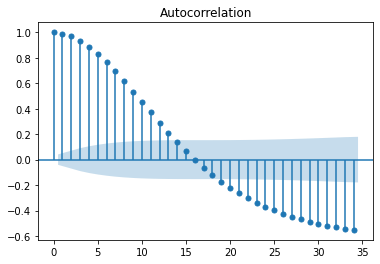

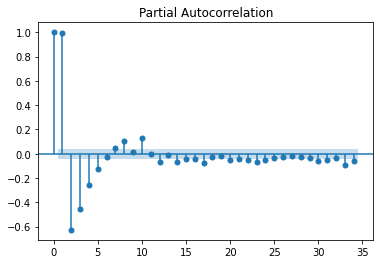

In [64]:
print(plot_acf(df1.google_pay))  # exponential decay
print(plot_pacf(df1.google_pay)) # number of significant lags

### Conclusion from the above plots for 'google_pay' attribute:
> - As we can see that in the ACF graph for every corresponding and continuous lag there is an exponential reduction in the correlation values so we can go ahead for AR model. 
> - Now we can check the PACF graph for furthur analysis and choosing the order for our model.
> - In the PACF graph, as the number of lag scale starts from 0 so this means that the first value is the value of correlation of the lag itself so we can ignore it.
> - Finally analyzing the graph from lag 1, we can acquire 

## 2. Plotting the graphs for paytm data


Figure(432x288)
Figure(432x288)


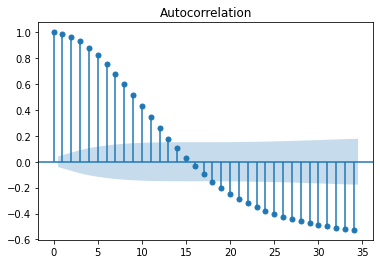

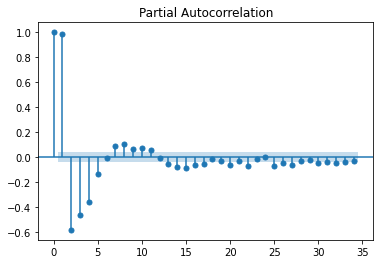

In [65]:
print(plot_acf(df1.paytm))
print(plot_pacf(df1.paytm))

## 3. Plotting the graphs for phone_pe data

Figure(432x288)
Figure(432x288)


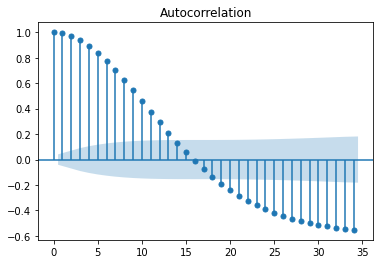

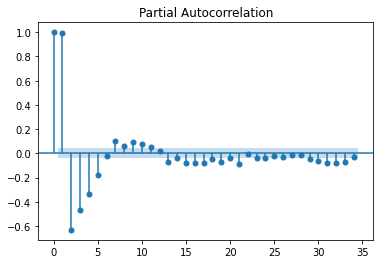

In [66]:
print(plot_acf(df1.phonepe))
print(plot_pacf(df1.phonepe))

## 4. Plotting the graphs for others attribute data

Figure(432x288)
Figure(432x288)


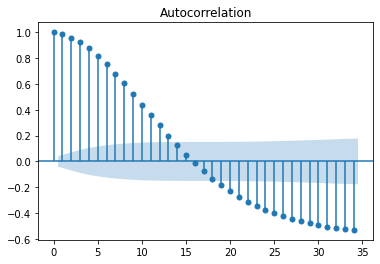

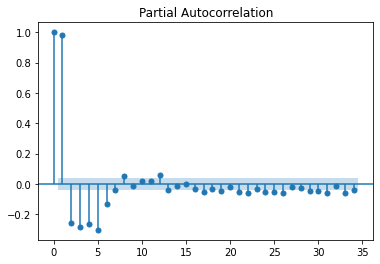

In [67]:
print(plot_acf(df1.others))
print(plot_pacf(df1.others))

<AxesSubplot:xlabel='date_'>

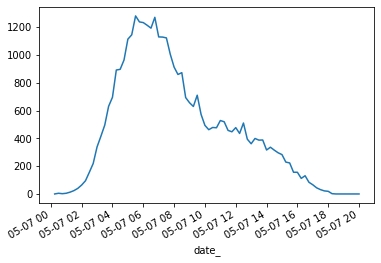

In [68]:
# training data

# testing data
df1.others.loc['2022-05-07 00:00:00':'2022-05-08 00:00:00'].plot()


In [69]:
df1.others

date_
2022-05-07 00:15:00       0.0
2022-05-07 00:30:00       5.0
2022-05-07 00:45:00       2.0
2022-05-07 01:00:00       5.0
2022-05-07 01:15:00      13.0
                        ...  
2022-06-06 06:45:00    1316.0
2022-06-06 07:00:00    1237.0
2022-06-06 07:15:00    1206.0
2022-06-06 07:30:00    1179.0
2022-06-06 07:45:00    1252.0
Name: others, Length: 2295, dtype: float64

In [70]:
string = "07 May 2015  00:15:00"
date = datetime.strptime(string, "%d %b %Y  %H:%M:%S")

print(date)

2015-05-07 00:15:00


In [71]:
type(date.year)

int

In [72]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Formulating Dataset for Prediction

> We are going to utilize Linear Regression model for modelling our data based on the timestamps as we are having continuous dataset.

> So we need to perform some transformations on our timestamp index, as our model cannot directly utilize timestamps as input.

> So we need to unravel our timestamps or generate some dummies in order to unify them.

- We will use time-step features which can be derived directly from the time index.
- The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.
- Linear regression with the time dummy produces the model:
> <b>target_outcome = weight * timestamp + bias</b>
- Here the time dummy lets us fit curves to time series in a time plot, where Time forms the x-axis.


In [73]:
df1['Time'] = np.arange(len(df1.index))

D:\College Softwares\Anaconda\envs\fsds_ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
# Our dataset
df1

google_pay  others   paytm  phonepe  Time
date_                                                         
2022-05-07 00:15:00         0.0     0.0     3.0      0.0     0
2022-05-07 00:30:00         0.0     5.0     2.0      5.0     1
2022-05-07 00:45:00         9.0     2.0     3.0      4.0     2
2022-05-07 01:00:00        23.0     5.0    13.0     26.0     3
2022-05-07 01:15:00        30.0    13.0    15.0     56.0     4
...                         ...     ...     ...      ...   ...
2022-06-06 06:45:00      4717.0  1316.0  1864.0   3471.0  2290
2022-06-06 07:00:00      4553.0  1237.0  1860.0   3289.0  2291
2022-06-06 07:15:00      4463.0  1206.0  1745.0   3171.0  2292
2022-06-06 07:30:00      4562.0  1179.0  1733.0   3143.0  2293
2022-06-06 07:45:00      4287.0  1252.0  1679.0   2856.0  2294

[2295 rows x 5 columns]

## Generic Outlier Function for Evaluation

In [119]:
def get_outlier_points(input_df):
    q1 = np.quantile(input_df, 0.25)
    q3 = np.quantile(input_df, 0.75)
    med = np.median(input_df)
    
    iqr = q3-q1
    
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    
    outliers = input_df[(input_df <= lower_bound) | (input_df >= upper_bound)]
    print('The following are the outliers in the boxplot:{}'.format(outliers))
    return outliers

## Creating training and testing datasets

In [120]:
# 80 %
train_end_index = int(.60*2295)

train_df = df1[df1.Time < train_end_index]

# 20 %
test_df = df1[df1.Time > train_end_index]

In [121]:
train_df

google_pay  others  paytm  phonepe  Time
date_                                                        
2022-05-07 00:15:00         0.0     0.0    3.0      0.0     0
2022-05-07 00:30:00         0.0     5.0    2.0      5.0     1
2022-05-07 00:45:00         9.0     2.0    3.0      4.0     2
2022-05-07 01:00:00        23.0     5.0   13.0     26.0     3
2022-05-07 01:15:00        30.0    13.0   15.0     56.0     4
...                         ...     ...    ...      ...   ...
2022-05-25 02:30:00       362.0   137.0  202.0    432.0  1372
2022-05-25 02:45:00       558.0   207.0  293.0    662.0  1373
2022-05-25 03:00:00       834.0   310.0  435.0    886.0  1374
2022-05-25 03:15:00      1052.0   391.0  540.0   1221.0  1375
2022-05-25 03:30:00       491.0   781.0  742.0   1703.0  1376

[1377 rows x 5 columns]

In [122]:
test_df

google_pay  others   paytm  phonepe  Time
date_                                                         
2022-05-25 04:00:00       282.0  1401.0  1269.0   2416.0  1378
2022-05-25 04:15:00       257.0  1661.0  1464.0   2711.0  1379
2022-05-25 04:30:00       260.0  1904.0  1647.0   3024.0  1380
2022-05-25 04:45:00       193.0  2020.0  1841.0   3200.0  1381
2022-05-25 05:00:00       178.0  2207.0  2028.0   3654.0  1382
...                         ...     ...     ...      ...   ...
2022-06-06 06:45:00      4717.0  1316.0  1864.0   3471.0  2290
2022-06-06 07:00:00      4553.0  1237.0  1860.0   3289.0  2291
2022-06-06 07:15:00      4463.0  1206.0  1745.0   3171.0  2292
2022-06-06 07:30:00      4562.0  1179.0  1733.0   3143.0  2293
2022-06-06 07:45:00      4287.0  1252.0  1679.0   2856.0  2294

[917 rows x 5 columns]

# Splitting the Features and Labels columns

# 1. For 'others' attribute for our Dataset

## Plotting the box-plot to visualize the anomalies in our Dataset for 'others' attribute

D:\College Softwares\Anaconda\envs\fsds_ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='others'>

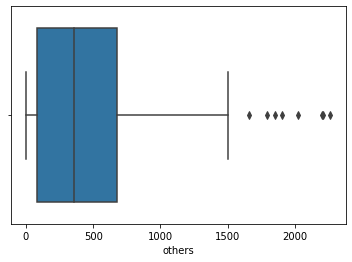

In [179]:
sns.boxplot(df1.others, orient='h')

In [123]:
x_train_others = train_df.loc[:,['Time']]
y_train_others = train_df.loc[:,'others']

x_test_others = test_df.loc[:,['Time']]
y_test_others = test_df.loc[:,'others']

In [124]:
x_train_others

Time
date_                    
2022-05-07 00:15:00     0
2022-05-07 00:30:00     1
2022-05-07 00:45:00     2
2022-05-07 01:00:00     3
2022-05-07 01:15:00     4
...                   ...
2022-05-25 02:30:00  1372
2022-05-25 02:45:00  1373
2022-05-25 03:00:00  1374
2022-05-25 03:15:00  1375
2022-05-25 03:30:00  1376

[1377 rows x 1 columns]

In [125]:
y_train_others

date_
2022-05-07 00:15:00      0.0
2022-05-07 00:30:00      5.0
2022-05-07 00:45:00      2.0
2022-05-07 01:00:00      5.0
2022-05-07 01:15:00     13.0
                       ...  
2022-05-25 02:30:00    137.0
2022-05-25 02:45:00    207.0
2022-05-25 03:00:00    310.0
2022-05-25 03:15:00    391.0
2022-05-25 03:30:00    781.0
Name: others, Length: 1377, dtype: float64

In [126]:
x_test_others

Time
date_                    
2022-05-25 04:00:00  1378
2022-05-25 04:15:00  1379
2022-05-25 04:30:00  1380
2022-05-25 04:45:00  1381
2022-05-25 05:00:00  1382
...                   ...
2022-06-06 06:45:00  2290
2022-06-06 07:00:00  2291
2022-06-06 07:15:00  2292
2022-06-06 07:30:00  2293
2022-06-06 07:45:00  2294

[917 rows x 1 columns]

In [127]:
y_test_others

date_
2022-05-25 04:00:00    1401.0
2022-05-25 04:15:00    1661.0
2022-05-25 04:30:00    1904.0
2022-05-25 04:45:00    2020.0
2022-05-25 05:00:00    2207.0
                        ...  
2022-06-06 06:45:00    1316.0
2022-06-06 07:00:00    1237.0
2022-06-06 07:15:00    1206.0
2022-06-06 07:30:00    1179.0
2022-06-06 07:45:00    1252.0
Name: others, Length: 917, dtype: float64

In [128]:
y_train_others,x_train_others = y_train_others.align(x_train_others, join='inner')

In [129]:
from sklearn.linear_model import LinearRegression

lr_others = LinearRegression()

lr_others.fit(x_train_others,y_train_others)

LinearRegression()

In [130]:
y_pred_others = pd.Series(lr_others.predict(x_test_others), index=x_test_others.index)
y_pred_others

date_
2022-05-25 04:00:00    383.798572
2022-05-25 04:15:00    383.723157
2022-05-25 04:30:00    383.647742
2022-05-25 04:45:00    383.572326
2022-05-25 05:00:00    383.496911
                          ...    
2022-06-06 06:45:00    315.019793
2022-06-06 07:00:00    314.944378
2022-06-06 07:15:00    314.868962
2022-06-06 07:30:00    314.793547
2022-06-06 07:45:00    314.718132
Length: 917, dtype: float64

In [131]:
# Acquiring anomaly points for others attribute
outlier_points_others = get_outlier_points(df1.others)

The following are the outliers in the boxplot:date_
2022-05-25 04:15:00    1661.0
2022-05-25 04:30:00    1904.0
2022-05-25 04:45:00    2020.0
2022-05-25 05:00:00    2207.0
2022-05-25 05:15:00    2263.0
2022-05-25 05:30:00    2201.0
2022-05-27 06:15:00    1855.0
2022-06-04 05:30:00    1789.0
Name: others, dtype: float64


In [132]:
## Generic Prediction Code **

x = df1.loc[:,['Time']]
y = df1.loc[:,'others']

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x,y)

y_pred = pd.Series(lr.predict(x), index=x.index)

Text(0.5, 1.0, 'Time Plot for others attribute')

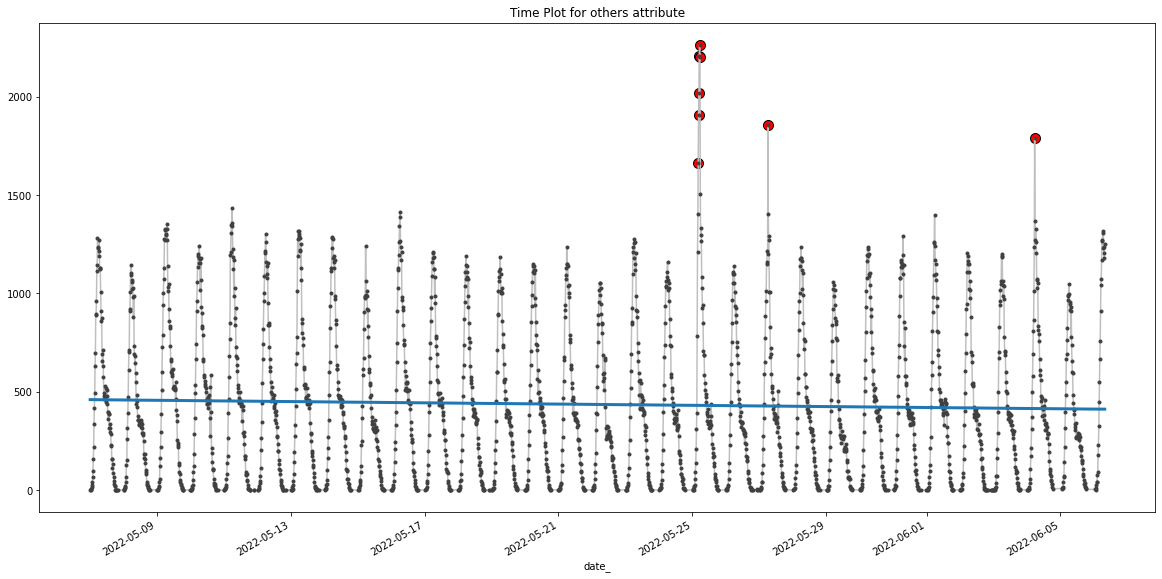

In [165]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    figsize=(20,10)
)
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
# ax = outlier_points.plot(ax=ax, )

outlier_y_others = list(outlier_points_others.values)
outlier_x_others = list(outlier_points_others.index)

plt.scatter(outlier_x_others, outlier_y_others, marker='o',c='red', edgecolors='black', s=100)
ax.set_title('Time Plot for others attribute')



# 2. For 'google_pay' attribute of our Dataset

## Plotting box-plot for visualizing the anomalies for our google_pay attribute

D:\College Softwares\Anaconda\envs\fsds_ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='google_pay'>

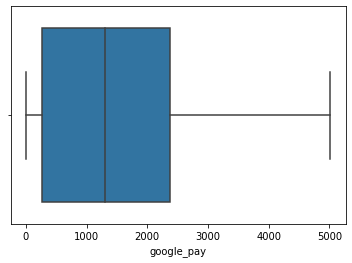

In [182]:
sns.boxplot(df1.google_pay, orient='h')

In [142]:
x_train_google_pay = train_df.loc[:,['Time']]
y_train_google_pay = train_df.loc[:,'google_pay']

x_test_google_pay = test_df.loc[:,['Time']]
y_test_google_pay = test_df.loc[:,'google_pay']

In [143]:
x_train_google_pay

Time
date_                    
2022-05-07 00:15:00     0
2022-05-07 00:30:00     1
2022-05-07 00:45:00     2
2022-05-07 01:00:00     3
2022-05-07 01:15:00     4
...                   ...
2022-05-25 02:30:00  1372
2022-05-25 02:45:00  1373
2022-05-25 03:00:00  1374
2022-05-25 03:15:00  1375
2022-05-25 03:30:00  1376

[1377 rows x 1 columns]

In [144]:
y_train_google_pay

date_
2022-05-07 00:15:00       0.0
2022-05-07 00:30:00       0.0
2022-05-07 00:45:00       9.0
2022-05-07 01:00:00      23.0
2022-05-07 01:15:00      30.0
                        ...  
2022-05-25 02:30:00     362.0
2022-05-25 02:45:00     558.0
2022-05-25 03:00:00     834.0
2022-05-25 03:15:00    1052.0
2022-05-25 03:30:00     491.0
Name: google_pay, Length: 1377, dtype: float64

In [145]:
x_test_google_pay

Time
date_                    
2022-05-25 04:00:00  1378
2022-05-25 04:15:00  1379
2022-05-25 04:30:00  1380
2022-05-25 04:45:00  1381
2022-05-25 05:00:00  1382
...                   ...
2022-06-06 06:45:00  2290
2022-06-06 07:00:00  2291
2022-06-06 07:15:00  2292
2022-06-06 07:30:00  2293
2022-06-06 07:45:00  2294

[917 rows x 1 columns]

In [146]:
y_test_google_pay

date_
2022-05-25 04:00:00     282.0
2022-05-25 04:15:00     257.0
2022-05-25 04:30:00     260.0
2022-05-25 04:45:00     193.0
2022-05-25 05:00:00     178.0
                        ...  
2022-06-06 06:45:00    4717.0
2022-06-06 07:00:00    4553.0
2022-06-06 07:15:00    4463.0
2022-06-06 07:30:00    4562.0
2022-06-06 07:45:00    4287.0
Name: google_pay, Length: 917, dtype: float64

In [147]:
y_train_google_pay,x_train_google_pay = y_train_google_pay.align(x_train_google_pay, join='inner')

In [148]:
from sklearn.linear_model import LinearRegression

lr_google_pay = LinearRegression()

lr_google_pay.fit(x_train_google_pay,y_train_google_pay)

LinearRegression()

In [149]:
y_pred_google_pay = pd.Series(lr_google_pay.predict(x_test_google_pay), index=x_test_google_pay.index)
y_pred_google_pay

date_
2022-05-25 04:00:00    1417.649456
2022-05-25 04:15:00    1417.426270
2022-05-25 04:30:00    1417.203084
2022-05-25 04:45:00    1416.979898
2022-05-25 05:00:00    1416.756712
                          ...     
2022-06-06 06:45:00    1214.103838
2022-06-06 07:00:00    1213.880652
2022-06-06 07:15:00    1213.657466
2022-06-06 07:30:00    1213.434280
2022-06-06 07:45:00    1213.211094
Length: 917, dtype: float64

In [150]:
outlier_points_google_pay = get_outlier_points(df1.google_pay)

The following are the outliers in the boxplot:Series([], Name: google_pay, dtype: float64)


In [ ]:
x = df1.loc[:,['Time']]
y = df1.loc[:,'google_pay']

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x,y)

y_pred = pd.Series(lr.predict(x), index=x.index)

Text(0.5, 1.0, 'Time Plot of google_pay attribute')

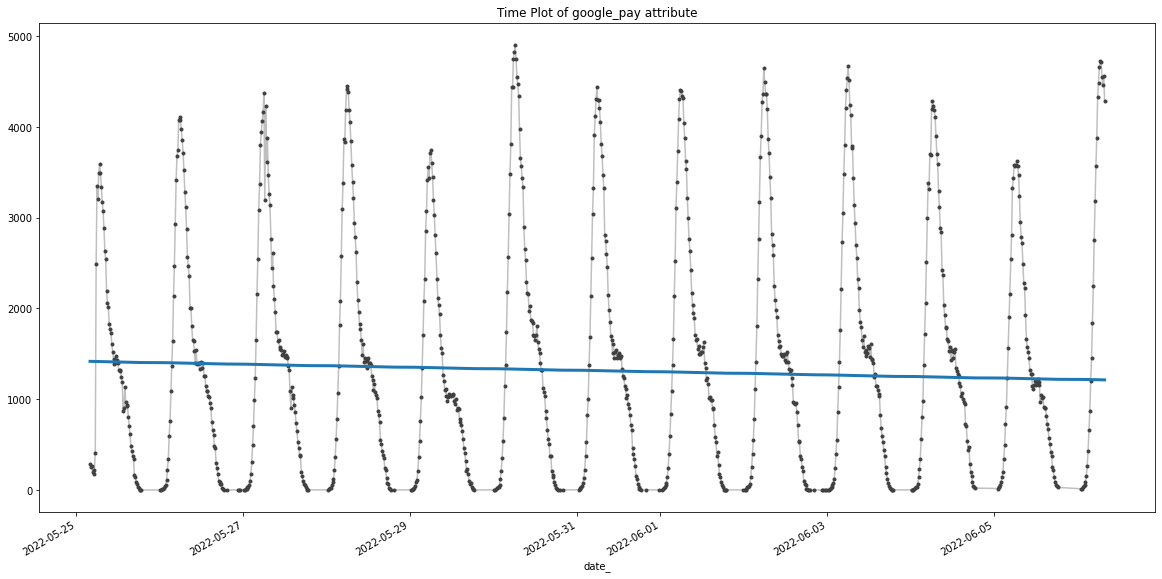

In [166]:

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    figsize=(20,10)
)
ax = y_test_google_pay.plot(**plot_params)
ax = y_pred_google_pay.plot(ax=ax, linewidth=3)
# ax = outlier_points.plot(ax=ax, )

outlier_y_google_pay = list(outlier_points_google_pay.values)
outlier_x_google_pay = list(outlier_points_google_pay.index)

plt.scatter(outlier_x_google_pay, outlier_y_google_pay, marker='o',c='red', edgecolors='black', s=100)
ax.set_title('Time Plot of google_pay attribute')



# 3. For 'phonepe' attribute of our Dataset

In [ ]:
## Plotting box-plot for visual

In [153]:
x_train_phonepe = train_df.loc[:,['Time']]
y_train_phonepe = train_df.loc[:,'phonepe']

x_test_phonepe = test_df.loc[:,['Time']]
y_test_phonepe = test_df.loc[:,'phonepe']

In [154]:
x_train_phonepe

Time
date_                    
2022-05-07 00:15:00     0
2022-05-07 00:30:00     1
2022-05-07 00:45:00     2
2022-05-07 01:00:00     3
2022-05-07 01:15:00     4
...                   ...
2022-05-25 02:30:00  1372
2022-05-25 02:45:00  1373
2022-05-25 03:00:00  1374
2022-05-25 03:15:00  1375
2022-05-25 03:30:00  1376

[1377 rows x 1 columns]

In [155]:
y_train_phonepe

date_
2022-05-07 00:15:00       0.0
2022-05-07 00:30:00       5.0
2022-05-07 00:45:00       4.0
2022-05-07 01:00:00      26.0
2022-05-07 01:15:00      56.0
                        ...  
2022-05-25 02:30:00     432.0
2022-05-25 02:45:00     662.0
2022-05-25 03:00:00     886.0
2022-05-25 03:15:00    1221.0
2022-05-25 03:30:00    1703.0
Name: phonepe, Length: 1377, dtype: float64

In [156]:
x_test_phonepe

Time
date_                    
2022-05-25 04:00:00  1378
2022-05-25 04:15:00  1379
2022-05-25 04:30:00  1380
2022-05-25 04:45:00  1381
2022-05-25 05:00:00  1382
...                   ...
2022-06-06 06:45:00  2290
2022-06-06 07:00:00  2291
2022-06-06 07:15:00  2292
2022-06-06 07:30:00  2293
2022-06-06 07:45:00  2294

[917 rows x 1 columns]

In [157]:
y_test_phonepe

date_
2022-05-25 04:00:00    2416.0
2022-05-25 04:15:00    2711.0
2022-05-25 04:30:00    3024.0
2022-05-25 04:45:00    3200.0
2022-05-25 05:00:00    3654.0
                        ...  
2022-06-06 06:45:00    3471.0
2022-06-06 07:00:00    3289.0
2022-06-06 07:15:00    3171.0
2022-06-06 07:30:00    3143.0
2022-06-06 07:45:00    2856.0
Name: phonepe, Length: 917, dtype: float64

In [158]:
y_train_phonepe,x_train_phonepe = y_train_phonepe.align(x_train_phonepe, join='inner')

In [159]:
from sklearn.linear_model import LinearRegression

lr_phonepe = LinearRegression()

lr_phonepe.fit(x_train_phonepe,y_train_phonepe)

LinearRegression()

In [160]:
y_pred_phonepe = pd.Series(lr_phonepe.predict(x_test_phonepe), index=x_test_phonepe.index)
y_pred_phonepe

date_
2022-05-25 04:00:00    1041.036887
2022-05-25 04:15:00    1040.862845
2022-05-25 04:30:00    1040.688802
2022-05-25 04:45:00    1040.514759
2022-05-25 05:00:00    1040.340716
                          ...     
2022-06-06 06:45:00     882.309930
2022-06-06 07:00:00     882.135887
2022-06-06 07:15:00     881.961844
2022-06-06 07:30:00     881.787802
2022-06-06 07:45:00     881.613759
Length: 917, dtype: float64

In [163]:
outlier_points_phonepe = get_outlier_points(df1.phonepe)

The following are the outliers in the boxplot:Series([], Name: phonepe, dtype: float64)


In [ ]:
x = df1.loc[:,['Time']]
y = df1.loc[:,'google_pay']

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x,y)

y_pred = pd.Series(lr.predict(x), index=x.index)

Text(0.5, 1.0, 'Time Plot of phonepe attribute')

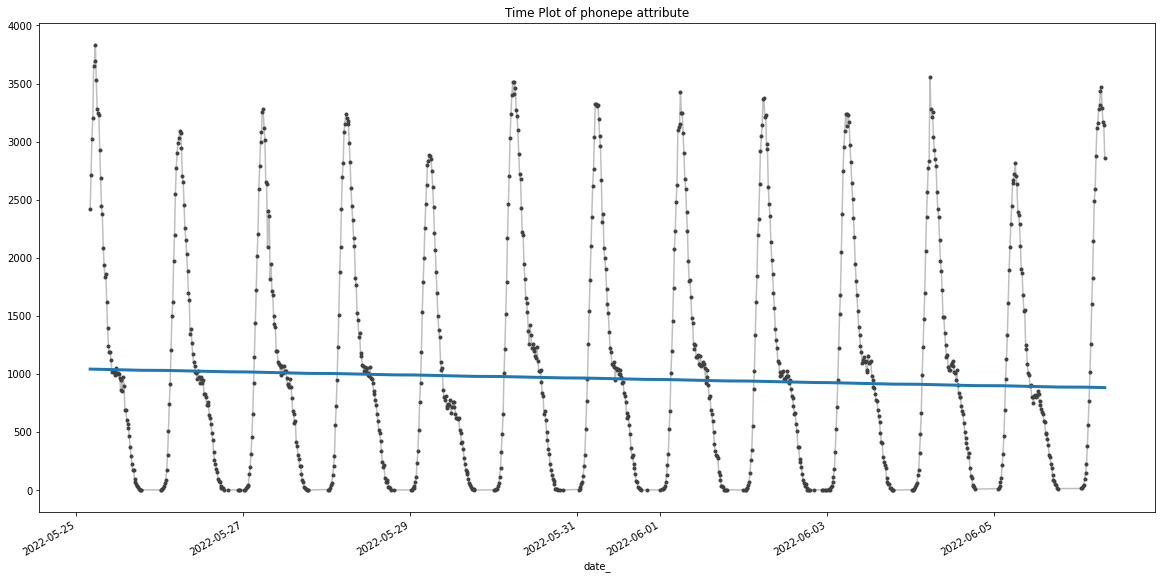

In [167]:

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    figsize=(20,10)
)
ax = y_test_phonepe.plot(**plot_params)
ax = y_pred_phonepe.plot(ax=ax, linewidth=3)
# ax = outlier_points.plot(ax=ax, )

outlier_y_phonepe = list(outlier_points_phonepe.values)
outlier_x_phonepe = list(outlier_points_phonepe.index)

plt.scatter(outlier_x_phonepe, outlier_y_phonepe, marker='o',c='red', edgecolors='black', s=100)
ax.set_title('Time Plot of phonepe attribute')



## 4. For 'paytm' attribute of our Dataset

In [168]:
x_train_paytm = train_df.loc[:,['Time']]
y_train_paytm = train_df.loc[:,'paytm']

x_test_paytm = test_df.loc[:,['Time']]
y_test_paytm = test_df.loc[:,'paytm']

In [169]:
x_train_paytm

Time
date_                    
2022-05-07 00:15:00     0
2022-05-07 00:30:00     1
2022-05-07 00:45:00     2
2022-05-07 01:00:00     3
2022-05-07 01:15:00     4
...                   ...
2022-05-25 02:30:00  1372
2022-05-25 02:45:00  1373
2022-05-25 03:00:00  1374
2022-05-25 03:15:00  1375
2022-05-25 03:30:00  1376

[1377 rows x 1 columns]

In [171]:
y_train_paytm

date_
2022-05-07 00:15:00      3.0
2022-05-07 00:30:00      2.0
2022-05-07 00:45:00      3.0
2022-05-07 01:00:00     13.0
2022-05-07 01:15:00     15.0
                       ...  
2022-05-25 02:30:00    202.0
2022-05-25 02:45:00    293.0
2022-05-25 03:00:00    435.0
2022-05-25 03:15:00    540.0
2022-05-25 03:30:00    742.0
Name: paytm, Length: 1377, dtype: float64

In [172]:
x_test_paytm

Time
date_                    
2022-05-25 04:00:00  1378
2022-05-25 04:15:00  1379
2022-05-25 04:30:00  1380
2022-05-25 04:45:00  1381
2022-05-25 05:00:00  1382
...                   ...
2022-06-06 06:45:00  2290
2022-06-06 07:00:00  2291
2022-06-06 07:15:00  2292
2022-06-06 07:30:00  2293
2022-06-06 07:45:00  2294

[917 rows x 1 columns]

In [173]:
y_test_paytm

date_
2022-05-25 04:00:00    1269.0
2022-05-25 04:15:00    1464.0
2022-05-25 04:30:00    1647.0
2022-05-25 04:45:00    1841.0
2022-05-25 05:00:00    2028.0
                        ...  
2022-06-06 06:45:00    1864.0
2022-06-06 07:00:00    1860.0
2022-06-06 07:15:00    1745.0
2022-06-06 07:30:00    1733.0
2022-06-06 07:45:00    1679.0
Name: paytm, Length: 917, dtype: float64

In [174]:
y_train_paytm,x_train_paytm = y_train_paytm.align(x_train_paytm, join='inner')

In [175]:
from sklearn.linear_model import LinearRegression

lr_paytm = LinearRegression()

lr_paytm.fit(x_train_paytm,y_train_paytm)

LinearRegression()

In [176]:
y_pred_paytm = pd.Series(lr_paytm.predict(x_test_paytm), index=x_test_paytm.index)
y_pred_paytm

date_
2022-05-25 04:00:00    617.633472
2022-05-25 04:15:00    617.524920
2022-05-25 04:30:00    617.416368
2022-05-25 04:45:00    617.307815
2022-05-25 05:00:00    617.199263
                          ...    
2022-06-06 06:45:00    518.633859
2022-06-06 07:00:00    518.525307
2022-06-06 07:15:00    518.416754
2022-06-06 07:30:00    518.308202
2022-06-06 07:45:00    518.199650
Length: 917, dtype: float64

In [177]:
outlier_points_paytm = get_outlier_points(df1.paytm)

The following are the outliers in the boxplot:Series([], Name: paytm, dtype: float64)


In [ ]:
x = df1.loc[:,['Time']]
y = df1.loc[:,'google_pay']

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x,y)

y_pred = pd.Series(lr.predict(x), index=x.index)

Text(0.5, 1.0, 'Time Plot of paytm attribute')

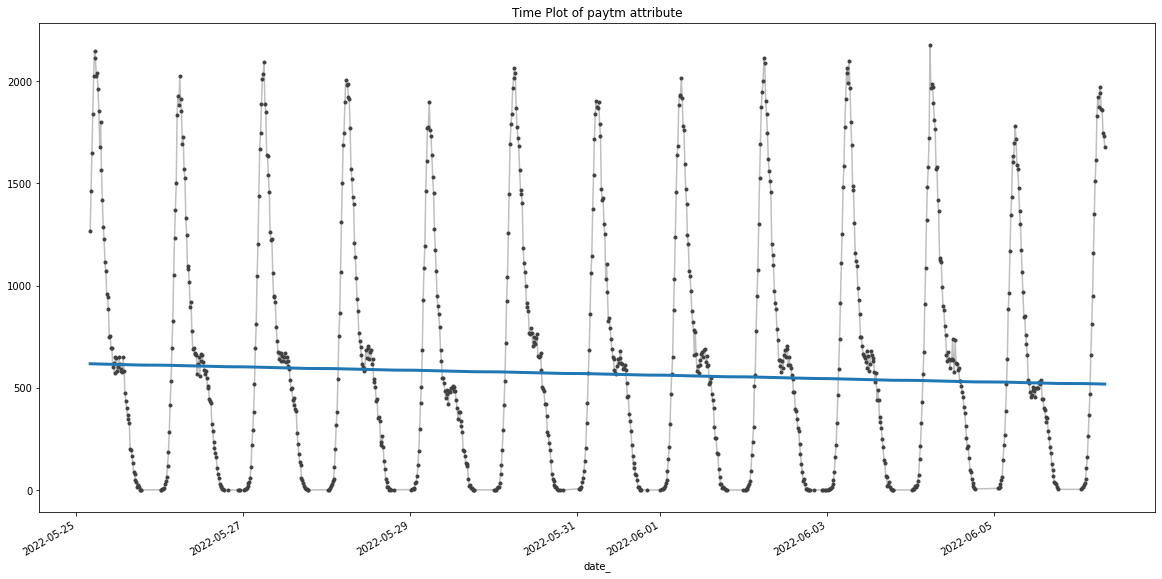

In [178]:

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    figsize=(20,10)
)
ax = y_test_paytm.plot(**plot_params)
ax = y_pred_paytm.plot(ax=ax, linewidth=3)
# ax = outlier_points.plot(ax=ax, )

outlier_y_paytm = list(outlier_points_paytm.values)
outlier_x_paytm = list(outlier_points_paytm.index)

plt.scatter(outlier_x_paytm, outlier_y_paytm, marker='o',c='red', edgecolors='black', s=100)
ax.set_title('Time Plot of paytm attribute')



In [ ]:
# Thinking to add a threshold
# clean_data = removed outlier



# df1.others[df1.others!=outlier_y].describe()
# # df1.others
for i in df1.others:
    print(i)

In [ ]:

sns.boxplot(df1.others, orient='h')

In [ ]:
df1

In [ ]:
model_ARIMA=ARIMA(df1.others,order=(8,0,0))
model_ARIMA.fit()

In [ ]:
# OLS -> Linear
# Facebook algo for forecasting


model_ARIMA.predict

In [ ]:
df1

In [ ]:
int(.25 * 2295)


In [ ]:
int(.75 * 2295)

In [ ]:
df1[:1721]

In [ ]:
"""
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
# evaluate parameters
p_values = [1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df1.google_pay, p_values, d_values, q_values)
"""

In [ ]:
df1.loc['2022-05-07 00:00:00':'2022-05-08 00:00:00']

In [ ]:
df1.loc['2022-05-07 00:00:00':'2022-05-08 00:00:00'].plot()

In [ ]:
df2 = df1.copy(deep=True)
df2['google_pay']=df2['google_pay']-df2['google_pay'].shift(72)

In [ ]:
df2.plot()

In [ ]:
plot_acf(df2.google_pay.dropna())
plot_pacf(df2.google_pay.dropna())

In [ ]:
df

# NEW

In [ ]:
# 15 mins for 1 month
df1

In [ ]:
df1.google_pay.plot()

In [ ]:
df1.google_pay.describe()

In [ ]:
df1.google_pay.isnull().sum()

In [ ]:
df1.google_pay.loc["2022-05-07 00:00:00" : "2022-05-08 00:00:00"].plot()

In [ ]:
df1.describe()

In [ ]:
# 2022-05-25
df1.google_pay.plot()

In [ ]:
df1.paytm.plot()

In [ ]:
df1.phonepe.plot()

In [ ]:
# 2022-05-25
df1.others.plot()

In [ ]:
df1.others.loc["2022-05-24 00:00:00" : "2022-05-27 00:00:00"].plot()

In [ ]:
import seaborn as sns

In [ ]:
sns.boxplot(df1.others, orient='h')

In [ ]:
sns.boxplot(df1.google_pay, orient='h')

In [ ]:
sns.boxplot(df1.paytm, orient='h')

In [ ]:
sns.boxplot(df1.phonepe, orient='h')

In [ ]:
sns.displot(df1)

In [ ]:
plt.boxplot(df1,labels=df1.columns)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression(normalize=True)

In [ ]:
df1.count()

In [ ]:
df2 = df1.copy(deep=True).reset_index()

In [ ]:
df2['date_']=df2['date_'].map(datetime.toordinal)
df2.info()

In [ ]:
train_end_date="2022-05-31 00:00:00"

train_set = df2.date_.loc[:train_end_date]
test_set = df2.date_.loc[train_end_date:]

In [ ]:
train_set

In [ ]:
test_set

In [ ]:
x_train = pd.DataFrame(train_set.date_)
x_test = pd.DataFrame(test_set.date_)

In [ ]:
y_train = pd.DataFrame(train_set.google_pay)
y_test = pd.DataFrame(test_set.google_pay)

In [ ]:
x_train

In [ ]:
x_test

In [ ]:
y_train

In [ ]:
y_test

In [ ]:
pd.DataFrame(train_set.google_pay)

In [ ]:
lr.fit(x_train, y_train)

In [ ]:
y_pred = lr.predict(pd.DataFrame(x_test))

In [ ]:
lr.score(x_test, y_test)

In [ ]:
df1.loc['2022-05-07 00:00:15':'2022-05-08 00:00:15']

In [ ]:
78*29

In [ ]:
df1

In [ ]:
df1

In [ ]:
df1.google_pay.loc["2022-05-07 00:00:00" : "2022-05-08 00:00:00"].plot()

In [ ]:
others = df1.others.copy(deep=True)

In [ ]:
# finding the 1st quartile
q1 = np.quantile(others, 0.25)
 
# finding the 3rd quartile
q3 = np.quantile(others, 0.75)
med = np.median(others)
 
# finding the iqr region
iqr = q3-q1

In [ ]:
iqr

In [ ]:
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

In [ ]:
outliers = others[(others <= lower_bound) | (others >= upper_bound)]
print('The following are the outliers in the boxplot:{}'.format(outliers))

# Detecting outlier points using boxplot()